In [3]:
!pip install kmeans-pytorch




# PANDAS NUMPY openpyxl RE fsspec huggingface_hub ast torch scikit-learn matplotlib yellowbrick cuml cupy
#pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
#pip install cuml-cu12 --extra-index-url=https://pypi.nvidia.com (for kmeans)
 

# pre

In [1]:
import pandas as pd
import numpy as np
import re
import ast
import torch
import torch.nn as nn
import torch.nn.functional as F


from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

from kmeans_pytorch import kmeans

# Show all rows
pd.set_option("display.max_rows", None)

# Show all columns
pd.set_option("display.max_columns", None)

# Make sure wide DataFrames don't wrap
pd.set_option("display.width", None)

# Show the full content of each column (no '...')
pd.set_option("display.max_colwidth", None)

In [2]:

print("CUDA Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0))
print("Total Memory (GB):", torch.cuda.get_device_properties(0).total_memory / 1024**3)


CUDA Available: True
GPU Name: NVIDIA L40S
Total Memory (GB): 44.98785400390625


In [3]:
file_path = r"C:\Arun_MIX\DRGHistoricalReviewInformation_11182025.txt"

df_hist = pd.read_csv(file_path, sep='|', dtype=str, low_memory=False)

print(df_hist.info())
df_hist.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 886092 entries, 0 to 886091
Columns: 282 entries, Payor to AdjustedSavings
dtypes: object(282)
memory usage: 1.9+ GB
None


,Payor,claimid,Client,Control_ID,Claim_Number,PaymentType,Group_Type,Payments,Tax_ID,Provider_ID,HospitalName,LOS,DISP_Code,ADRG,DischargeYear,DischargeMonth,AGE,A_CCCount,A_MCCCount,B_CCCount,B_MCCCount,LOB,MRREQ,MRREC,PRIM_DX,A_DX2,A_DX3,A_DX4,A_DX5,A_DX6,A_DX7,A_DX8,A_DX9,A_DX10,A_DX11,A_DX12,A_DX13,A_DX14,A_DX15,A_DX16,A_DX17,A_DX18,A_DX19,A_DX20,A_DX21,A_DX22,A_DX23,A_DX24,A_DX25,A_POA,A_POA2,A_POA3,A_POA4,A_POA5,A_POA6,A_POA7,A_POA8,A_POA9,A_POA10,A_POA11,A_POA12,A_POA13,A_POA14,A_POA15,A_POA16,A_POA17,A_POA18,A_POA19,A_POA20,A_POA21,A_POA22,A_POA23,A_POA24,A_POA25,A_PX1,A_PX2,A_PX3,A_PX4,A_PX5,A_PX6,A_PX7,A_PX8,A_PX9,A_PX10,A_PX11,A_PX12,A_PX13,A_PX14,A_PX15,A_PX16,A_PX17,A_PX18,A_PX19,A_PX20,A_PX21,A_PX22,A_PX23,A_PX24,A_PX25,B_DISPCode,B_DenialCode,B_DRG,B_PRIMDX,B_DX2,B_DX3,B_DX4,B_DX5,B_DX6,B_DX7,B_DX8,B_DX9,B_DX10,B_DX11,B_DX12,B_DX13,B_DX14,B_DX15,B_DX16,B_DX17,B_DX18,B_DX19,B_DX20,B_DX21,B_DX22,B_DX23,B_DX24,B_DX25,B_POA,B_POA2,B_POA3,B_POA4,B_POA5,B_POA6,B_POA7,B_POA8,B_POA9,B_POA10,B_POA11,B_POA12,B_POA13,B_POA14,B_POA15,B_POA16,B_POA17,B_POA18,B_POA19,B_POA20,B_POA21,B_POA22,B_POA23,B_POA24,B_POA25,B_PX1,B_PX2,B_PX3,B_PX4,B_PX5,B_PX6,B_PX7,B_PX8,B_PX9,B_PX10,B_PX11,B_PX12,B_PX13,B_PX14,B_PX15,B_PX16,B_PX17,B_PX18,B_PX19,B_PX20,B_PX21,B_PX22,B_PX23,B_PX24,B_PX25,A_PRIMDX_Desc,A_DX2_Desc,A_DX3_Desc,A_DX4_Desc,A_DX5_Desc,A_DX6_Desc,A_DX7_Desc,A_DX8_Desc,A_DX9_Desc,A_DX10_Desc,A_DX11_Desc,A_DX12_Desc,A_DX13_Desc,A_DX14_Desc,A_DX15_Desc,A_DX16_Desc,A_DX17_Desc,A_DX18_Desc,A_DX19_Desc,A_DX20_Desc,A_DX21_Desc,A_DX22_Desc,A_DX23_Desc,A_DX24_Desc,A_DX25_Desc,A_PX1_Desc,A_PX2_Desc,A_PX3_Desc,A_PX4_Desc,A_PX5_Desc,A_PX6_Desc,A_PX7_Desc,A_PX8_Desc,A_PX9_Desc,A_PX10_Desc,A_PX11_Desc,A_PX12_Desc,A_PX13_Desc,A_PX14_Desc,A_PX15_Desc,A_PX16_Desc,A_PX17_Desc,A_PX18_Desc,A_PX19_Desc,A_PX20_Desc,A_PX21_Desc,A_PX22_Desc,A_PX23_Desc,A_PX24_Desc,A_PX25_Desc,B_PRIMDX_Desc,B_DX2_Desc,B_DX3_Desc,B_DX4_Desc,B_DX5_Desc,B_DX6_Desc,B_DX7_Desc,B_DX8_Desc,B_DX9_Desc,B_DX10_Desc,B_DX11_Desc,B_DX12_Desc,B_DX13_Desc,B_DX14_Desc,B_DX15_Desc,B_DX16_Desc,B_DX17_Desc,B_DX18_Desc,B_DX19_Desc,B_DX20_Desc,B_DX21_Desc,B_DX22_Desc,B_DX23_Desc,B_DX24_Desc,B_DX25_Desc,B_PX1_Desc,B_PX2_Desc,B_PX3_Desc,B_PX4_Desc,B_PX5_Desc,B_PX6_Desc,B_PX7_Desc,B_PX8_Desc,B_PX9_Desc,B_PX10_Desc,B_PX11_Desc,B_PX12_Desc,B_PX13_Desc,B_PX14_Desc,B_PX15_Desc,B_PX16_Desc,B_PX17_Desc,B_PX18_Desc,B_PX19_Desc,B_PX20_Desc,B_PX21_Desc,B_PX22_Desc,B_PX23_Desc,B_PX24_Desc,B_PX25_Desc,InitialDeterminationDate,InitialDenialType,InitialDeterminationStatus,IDSavings,AdjustedSavings
0,UHC CSP,758656,NY,EXPR101623-340919,23N652771000,PrePay,01,15948.41,141340054,000334584002,ST LUKES CORNWALL HOSPITAL,9,02-TRNSF ACUTE CARE FAC,432,2023,9,69,2,2,2,2,NYCARE,2023-10-17 16:38:04.687000000,2023-11-08 00:00:00,K7030,I8511 - MCC,N170 - MCC,K766 - CC,D62 - CC,E119,K7682,F1010,I10,E039,Z794,K3189,E785,Z20822,Z87891,Z7984,Z751,Z741,Z7409,NaN,NaN,NaN,NaN,NaN,NaN,Y,Y,N,Y,Y,Y,Y,Y,Y,Y,,Y,Y,Y,,,,Y,Y,NaN,NaN,NaN,NaN,NaN,NaN,30233N1,06L38CZ,06L38CZ,0BH17EZ,5A1945Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,02-TRNSF ACUTE CARE FAC,NaN,432,K7030,I8511 - MCC,N170 - MCC,K766 - CC,D62 - CC,E119,K7682,F1010,I10,E039,Z794,K3189,E785,Z20822,Z87891,Z7984,Z751,Z741,Z7409,NaN,NaN,NaN,NaN,NaN,NaN,Y,Y,N,Y,Y,Y,Y,Y,Y,Y,NaN,Y,Y,Y,NaN,NaN,NaN,Y,Y,NaN,NaN,NaN,NaN,NaN,NaN,30233N1,06L38CZ,06L38CZ,0BH17EZ,5A1945Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Alcoholic cirrhosis of liver without ascites,Secondary esophageal varices with bleeding,Acute kidney failure with tubular necrosis,Portal hypertension,Acute posthemorrhagic anemia,Type 2 diabetes mellitus without complications,Hepatic encephalopathy,"Alcohol abuse, uncomplicated",Essential (primary) hypertension,"Hypothyroidism, unspecified",Long term (current) use of insulin,Other diseases of stomach and duodenum,"Hyperlipidemia, unspecified",Contact with and (suspected) exposure to COVID-19,Personal his

In [4]:
df1 = df_hist[df_hist['Client']=='Hum']

df1['PaymentType'] = df1['PaymentType'].str.strip().str.lower()

print(df1['InitialDenialType'].value_counts())

df1 = df1[(df1["InitialDeterminationStatus"].isin(["Approved", "Denied"])) & (df1["InitialDenialType"] == "Substantive")]

cols_to_drop = [
    'claimid', 'Control_ID', 'Claim_Number', 'Tax_ID',
    'DISP_Code', 'DischargeYear', 'DischargeMonth',
    'MRREQ', 'MRREC', 
    'InitialDeterminationDate', 'InitialDenialType',
    
]

df1 = df1.drop(columns=cols_to_drop, errors='ignore')


adx_cols = [f"A_DX{i}" for i in range(2, 26)]
#apx_cols = [f"A_PX{i}" for i in range(1, 26)]
bdx_cols = [f"B_DX{i}" for i in range(2, 26)]
#bpx_cols = [f"B_PX{i}" for i in range(1, 26)]

df1["A_DX_List"] = df1[adx_cols].values.tolist()
#df1["A_PX_List"] = df1[apx_cols].values.tolist()
df1["B_DX_List"] = df1[bdx_cols].values.tolist()
#df1["B_PX_List"] = df1[bpx_cols].values.tolist()


df1["A_DX_List"] = df1["A_DX_List"].apply(lambda x: sorted([i for i in x if pd.notna(i)]))
#df1["A_PX_List"] = df1["A_PX_List"].apply(lambda x: sorted([i for i in x if pd.notna(i)]))
df1["B_DX_List"] = df1["B_DX_List"].apply(lambda x: sorted([i for i in x if pd.notna(i)]))
#df1["B_PX_List"] = df1["B_PX_List"].apply(lambda x: sorted([i for i in x if pd.notna(i)]))


columns_to_keep = [
    "Client", "PaymentType", "Payments",
    "Provider_ID", "HospitalName", "LOS", "ADRG", "AGE", 
    "PRIM_DX", "B_DRG", "B_PRIMDX",
    "InitialDeterminationStatus", "IDSavings", 
    "A_DX_List", "B_DX_List"
]

df2 = df1[columns_to_keep]

def clean_sdx_list(lst):
    cleaned = []
    for item in lst:
        item = str(item).upper().strip()               # normalize
        item = item.replace("- MCC", "")               # remove MCC
        item = item.replace("- CC", "")                # remove CC
        item = item.replace("MCC", "")                 # safety
        item = item.replace("CC", "")                  # safety
        cleaned.append(item.strip().replace("-", ""))  # final cleanup
    return cleaned
df2["A_DX_List_Clean"] = df2["A_DX_List"].apply(clean_sdx_list)
df2["B_DX_List_Clean"] = df2["B_DX_List"].apply(clean_sdx_list)


def clean_dx_code(x):
    if pd.isna(x):
        return ""
    
    # Convert to string and normalize
    x = str(x).upper().strip()
    
    # Remove square brackets if any
    x = x.replace("[", "").replace("]", "")
    
    # Remove MCC / CC suffixes
    x = x.replace("- MCC", "").replace("- CC", "")
    x = x.replace("MCC", "").replace("CC", "")
    
    # Remove leftover hyphens
    x = x.replace("-", "")
    
    return x
df2["B_PRIMDX_Clean"] = df2["B_PRIMDX"].apply(clean_dx_code)

# ---------------------------------------------------------
# Step 1: Load MCC/CC Mapping File
# ---------------------------------------------------------
mccandcclist_df = pd.read_excel(r"C:\Arun_MIX\MCCCCList.xlsx")
mccandcclist_df['ICDCode'] = (
    mccandcclist_df['ICDCode']
    .astype(str)
    .str.strip()
    .str.upper()
)
mccandcclist = dict(zip(mccandcclist_df['ICDCode'], mccandcclist_df['MCCorCC']))
print(f"✅ Loaded MCC/CC list with {len(mccandcclist)} entries.")
mccandcclist_df.head()


def map_sdx_types(icd_list, lookup_dict):
    cleaned_list = []
    for code in icd_list:
        code_clean = str(code).strip().upper()  # normalize

        tag = lookup_dict.get(code_clean, "")  # MCC / CC / General
        cleaned_list.append(f"{code_clean} - {tag}")

    return cleaned_list

df2['A_DX_Type_list'] = df2['A_DX_List_Clean'].apply(lambda x: map_sdx_types(x, mccandcclist))
df2['B_DX_Type_list'] = df2['B_DX_List_Clean'].apply(lambda x: map_sdx_types(x, mccandcclist))


def extract_sdx_info(sdx_list):
    # Separate entries by type
    mcc = [x.split(" - ")[0] for x in sdx_list if "- MCC" in x]
    cc  = [x.split(" - ")[0] for x in sdx_list if "- CC" in x]
    #general  = [x.split(" - ")[0] for x in sdx_list if "- General" in x]
    other = [x.split(" - ")[0] for x in sdx_list if "- MCC" not in x and "- CC" not in x  ]

    # Determine SDX_Type and SDX_Set
    if mcc:
        return "MCC", mcc
    elif cc:
        return "CC", cc
    #elif general:
       # return "General", general
    
    else:
        return "General", other
    
# Apply the logic
df2[["A_DX_Type", "A_DX_Set"]] = df2["A_DX_Type_list"].apply(lambda x: pd.Series(extract_sdx_info(x)))

df2[["B_DX_Type", "B_DX_Set"]] = df2["B_DX_Type_list"].apply(lambda x: pd.Series(extract_sdx_info(x)))

# condition: SDX_Set empty AND SDX_Type == "General"
mask = (df2['A_DX_Set'].apply(lambda x: len(x) == 0)) & (df2['A_DX_Type'] == 'General')
mask = (df2['B_DX_Set'].apply(lambda x: len(x) == 0)) & (df2['B_DX_Type'] == 'General')
# update SDX_Type
df2.loc[mask, 'A_DX_Type'] = 'No A_DX'
df2.loc[mask, 'B_DX_Type'] = 'No B_DX'

#df2["A_PX_count"]  = df2["A_PX_List"].apply(lambda x: len([i for i in x if pd.notna(i)]))
#df2["B_PX_count"]  = df2["B_PX_List"].apply(lambda x: len([i for i in x if pd.notna(i)]))

df2["A_DX_Count"] = df2["A_DX_Set"].apply(lambda x: len([i for i in x if pd.notna(i)]))
df2["B_DX_Count"] = df2["B_DX_Set"].apply(lambda x: len([i for i in x if pd.notna(i)]))

cols_to_drop = [
    "A_DX_List", "B_DX_List","B_PRIMDX",
    "A_DX_List_Clean", "B_DX_List_Clean",
    "A_DX_Type_list", "B_DX_Type_list"
]

df2 = df2.drop(columns=cols_to_drop, errors='ignore')

def compare_dx_sets(a, b):
    # Convert to string so list formatting does not matter
    a_str = str(a).strip()
    b_str = str(b).strip()

    if a_str == b_str:
        return "No Change"   # Or np.nan if you want blank
    else:
        return f"Change {a_str} → {b_str}"

df2["DX_Change_Status"] = df2.apply(lambda row: compare_dx_sets(row["PRIM_DX"], row["B_PRIMDX_Clean"]),axis=1)

df2 = df2.replace("No B_DX", "No A_DX")

df2["DX_Type_Status"] = df2.apply(lambda row: compare_dx_sets(row["A_DX_Type"], row["B_DX_Type"]),axis=1)

df2["DRG_Status"] = df2.apply(
    lambda row: compare_dx_sets(row["ADRG"], row["B_DRG"]),
    axis=1
)


def compare_dx_lists(a, b):
    # Handle None or NaN
    if a is None or (isinstance(a, float) and np.isnan(a)):
        a = []
    if b is None or (isinstance(b, float) and np.isnan(b)):
        b = []
    
    # Make sure both are lists
    if not isinstance(a, list):
        a = [a]
    if not isinstance(b, list):
        b = [b]
    
    # Normalize codes
    a_clean = [str(code).upper().strip() for code in a]
    b_clean = [str(code).upper().strip() for code in b]
    
    # Compare as sets (order-insensitive)
    if set(a_clean) == set(b_clean):
        return "No Change"
    else:
        return f"Change {a_clean} → {b_clean}"


# Apply to dataframe
df2["DX_Set_Change_Status"] = df2.apply(
    lambda row: compare_dx_lists(row["A_DX_Set"], row["B_DX_Set"]),
    axis=1
)

# Apply to dataframe
#df2["PX_Set_Change_Status"] = df2.apply(
 #   lambda row: compare_dx_lists(row["A_PX_List"], row["B_PX_List"]),
 #   axis=1
#)

# Ensure numeric
df2['Payments'] = pd.to_numeric(df2['Payments'], errors='coerce')
df2['IDSavings'] = pd.to_numeric(df2['IDSavings'], errors='coerce')
# Ensure numeric
df2['LOS'] = pd.to_numeric(df2['LOS'], errors='coerce')
df2['AGE'] = pd.to_numeric(df2['AGE'], errors='coerce')


C:\Users\arunkumara\AppData\Local\Temp\4\ipykernel_8132\3799500579.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['PaymentType'] = df1['PaymentType'].str.strip().str.lower()


InitialDenialType
Substantive    64924
Name: count, dtype: int64


C:\Users\arunkumara\AppData\Local\Temp\4\ipykernel_8132\3799500579.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["A_DX_List_Clean"] = df2["A_DX_List"].apply(clean_sdx_list)
C:\Users\arunkumara\AppData\Local\Temp\4\ipykernel_8132\3799500579.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["B_DX_List_Clean"] = df2["B_DX_List"].apply(clean_sdx_list)
C:\Users\arunkumara\AppData\Local\Temp\4\ipykernel_8132\3799500579.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

✅ Loaded MCC/CC list with 17913 entries.


C:\Users\arunkumara\AppData\Local\Temp\4\ipykernel_8132\3799500579.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['A_DX_Type_list'] = df2['A_DX_List_Clean'].apply(lambda x: map_sdx_types(x, mccandcclist))
C:\Users\arunkumara\AppData\Local\Temp\4\ipykernel_8132\3799500579.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['B_DX_Type_list'] = df2['B_DX_List_Clean'].apply(lambda x: map_sdx_types(x, mccandcclist))
C:\Users\arunkumara\AppData\Local\Temp\4\ipykernel_8132\3799500579.py:129: Setti

In [5]:
df2.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 64924 entries, 1719 to 886078
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Client                      64924 non-null  object 
 1   PaymentType                 64924 non-null  object 
 2   Payments                    64924 non-null  float64
 3   Provider_ID                 64924 non-null  object 
 4   HospitalName                64924 non-null  object 
 5   LOS                         64924 non-null  int64  
 6   ADRG                        64924 non-null  object 
 7   AGE                         64924 non-null  int64  
 8   PRIM_DX                     64924 non-null  object 
 9   B_DRG                       64705 non-null  object 
 10  InitialDeterminationStatus  64924 non-null  object 
 11  IDSavings                   64924 non-null  float64
 12  B_PRIMDX_Clean              64924 non-null  object 
 13  A_DX_Type                   6492

In [6]:
df2['InitialDeterminationStatus'].value_counts()

InitialDeterminationStatus
Approved    56906
Denied       8018
Name: count, dtype: int64

# Clustering

In [7]:
df2['A_DX_Set'] = df2['A_DX_Set'].apply(
    lambda x: tuple(sorted([str(i).strip().upper() for i in x])) 
              if isinstance(x, list) else tuple()
)

df2['B_DX_Set'] = df2['B_DX_Set'].apply(
    lambda x: tuple(sorted([str(i).strip().upper() for i in x])) 
              if isinstance(x, list) else tuple()
)
df2.head()


,Client,PaymentType,Payments,Provider_ID,HospitalName,LOS,ADRG,AGE,PRIM_DX,B_DRG,InitialDeterminationStatus,IDSavings,B_PRIMDX_Clean,A_DX_Type,A_DX_Set,B_DX_Type,B_DX_Set,A_DX_Count,B_DX_Count,DX_Change_Status,DX_Type_Status,DRG_Status,DX_Set_Change_Status
1719,Hum,postpay,4277.47,593458145N,TAMPA GENERAL HOSPITAL,6,8613,60,G893,8613,Approved,0.0,G893,MCC,"(A419,)",MCC,"(A419,)",1,1,No Change,No Change,No Change,No Change
1720,Hum,postpay,9642.73,592616017M,UNIV OF MIAMI HOSP AND CLINICS,8,6953,40,Z5111,6953,Approved,0.0,Z5111,MCC,"(D61810,)",MCC,"(D61810,)",1,1,No Change,No Change,No Change,No Change
1721,Hum,postpay,7815.43,000045770H,NOVANT HEALTH PRESBYTERIAN MED,9,189,76,J9601,189,Approved,0.0,J9601,MCC,"(E1110, I2609, I5023, J9602)",MCC,"(E1110, I2609, I5023, J9602)",4,4,No Change,No Change,No Change,No Change
1722,Hum,postpay,15539.61,001825011C,SPARTANBURG REGIONAL MEDICAL C,16,539,63,M4626,539,Approved,0.0,M4626,MCC,"(G061, K6812)",MCC,"(G061, K6812)",2,2,No Change,No Change,No Change,No Change
1723,Hum,postpay,9020.75,381428164,MCLAREN OAKLAND,7,682,79,I120,682,Approved,0.0,I120,MCC,"(N186,)",MCC,"(N186,)",1,1,No Change,No Change,No Change,No Change


In [8]:
def compare_dx_sets(a, b):
    # Convert to string so list formatting does not matter
    a_str = str(a).strip()
    b_str = str(b).strip()

    if a_str == b_str:
        return "No Change"   # Or np.nan if you want blank
    else:
        return f"Change"

df2["Prim_DX_Change_Status"] = df2.apply(lambda row: compare_dx_sets(row["PRIM_DX"], row["B_PRIMDX_Clean"]),axis=1)

#df3 = df3.replace("No B_DX", "No A_DX")

df2["SDX_Type_ChangeStatus"] = df2.apply(lambda row: compare_dx_sets(row["A_DX_Type"], row["B_DX_Type"]),axis=1)

df2["DRG_Change_Status"] = df2.apply(
    lambda row: compare_dx_sets(row["ADRG"], row["B_DRG"]),
    axis=1
)


def compare_dx_lists(a, b):
    # Handle None or NaN
    if a is None or (isinstance(a, float) and np.isnan(a)):
        a = []
    if b is None or (isinstance(b, float) and np.isnan(b)):
        b = []
    
    # Make sure both are lists
    if not isinstance(a, list):
        a = [a]
    if not isinstance(b, list):
        b = [b]
    
    # Normalize codes
    a_clean = [str(code).upper().strip() for code in a]
    b_clean = [str(code).upper().strip() for code in b]
    
    # Compare as sets (order-insensitive)
    if set(a_clean) == set(b_clean):
        return "No Change"
    else:
        return f"Change"


# Apply to dataframe
df2["SDX_Set_Change_Status"] = df2.apply(
    lambda row: compare_dx_lists(row["A_DX_Set"], row["B_DX_Set"]),
    axis=1
)

df2.info()



<class 'pandas.core.frame.DataFrame'>
Index: 64924 entries, 1719 to 886078
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Client                      64924 non-null  object 
 1   PaymentType                 64924 non-null  object 
 2   Payments                    64924 non-null  float64
 3   Provider_ID                 64924 non-null  object 
 4   HospitalName                64924 non-null  object 
 5   LOS                         64924 non-null  int64  
 6   ADRG                        64924 non-null  object 
 7   AGE                         64924 non-null  int64  
 8   PRIM_DX                     64924 non-null  object 
 9   B_DRG                       64705 non-null  object 
 10  InitialDeterminationStatus  64924 non-null  object 
 11  IDSavings                   64924 non-null  float64
 12  B_PRIMDX_Clean              64924 non-null  object 
 13  A_DX_Type                   6492

In [9]:
def extract_unique_icd(df, col_name="dummy"):
    unique_icd = set()
    invalid_entries = []  # store invalid values with row index for inspection

    for idx, val in df[col_name].items():
        icd_list = []

        # ✅ Case 1: already a tuple
        if isinstance(val, tuple):
            icd_list = val

        # ✅ Case 2: comma-separated string
        elif isinstance(val, str):
            icd_list = tuple(val.split(","))

        # 🚫 Case 3: invalid type
        else:
            invalid_entries.append({"index": idx, "invalid_value": val})
            continue

        # 🔥 Clean + strip + uppercase each ICD code
        cleaned = [
            re.sub(r"[^A-Za-z0-9.\-]", "", str(icd).strip()).upper()
            for icd in icd_list
            if str(icd).strip()  # not empty
        ]

        unique_icd.update(cleaned)

    # ✅ Create DataFrame for valid ICDs
    unique_icd_df = pd.DataFrame(sorted(unique_icd), columns=["Unique_ICD"])
    unique_icd_df = unique_icd_df[
        unique_icd_df["Unique_ICD"].astype(str).str.strip() != ""
    ].reset_index(drop=True)

    # ⚠️ Invalid entries
    invalid_df = pd.DataFrame(invalid_entries)

    return unique_icd_df, invalid_df



# ✅ Example usage:
unique_icd_df, invalid_df = extract_unique_icd(df2, "A_DX_Set")
unique_icd_df1, invalid_df1 = extract_unique_icd(df2, "B_DX_Set")

# ✅ Strip spaces and get unique values (for another column like PRIM_DX)
unique_values = df2['PRIM_DX'].astype(str).str.strip().str.upper().unique()
unique_values1 = df2['B_PRIMDX_Clean'].astype(str).str.strip().str.upper().unique()


# ✅ Convert to a DataFrame
unique_df = pd.DataFrame(unique_values, columns=['Unique_ICD']) 
unique_df1 = pd.DataFrame(unique_values, columns=['Unique_ICD']) 

# 2️⃣ Concatenate and drop duplicates
union_df2 = pd.concat([unique_icd_df,unique_icd_df1, unique_df,unique_df1], ignore_index=True).drop_duplicates().reset_index(drop=True)

union_df2.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5747 entries, 0 to 5746
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unique_ICD  5747 non-null   object
dtypes: object(1)
memory usage: 45.0+ KB


In [10]:
# Load dataset
pretrained_embedding = pd.read_json("hf://datasets/attuneengineering/ICD_10_Embedding_Collection/ICD_10_embedding_collection.json")
#print(pretrained_embedding.info())
#pretrained_embedding.head()

# Create new DataFrame with only the 3 columns
df_pretrained = pretrained_embedding[['id', 'embedding']].copy()
df_pretrained['id'] = df_pretrained['id'].astype(str).str.strip().str.upper()

c:\Users\arunkumara\.conda\envs\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
union_df = union_df2.merge(df_pretrained,how='left',left_on='Unique_ICD',right_on='id')
# Replace NaN with list of 512 zeros
union_df['embedding'] = union_df['embedding'].apply(
    lambda x: [0.0]*512 if isinstance(x, float) and pd.isna(x) else x
)
union_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5747 entries, 0 to 5746
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unique_ICD  5747 non-null   object
 1   id          5701 non-null   object
 2   embedding   5747 non-null   object
dtypes: object(3)
memory usage: 134.8+ KB


In [12]:
"""nan = union_df[union_df['id'].isna()]
nan.head()

nan_list = nan['Unique_ICD'].dropna().unique().tolist()
nan_list

#check_list = ["E1110", "I2609", "I5023", "J9602"]

# 1️⃣ PRIM_DX match (single string)
df_1 = df3[df3['PRIM_DX'].isin(nan_list)]

# 2️⃣ B_PRIMDX_Clean match (single string)
df_2 = df3[df3['B_PRIMDX_Clean'].isin(nan_list)]

# 3️⃣ A_DX_Set match (tuple/list)
df_3 = df3[
    df3['A_DX_Set'].apply(
        lambda x: any(item in nan_list for item in x) if isinstance(x, (list, tuple)) else False
    )
]

# 3️⃣ A_DX_Set match (tuple/list)
df_4 = df3[
    df3['B_DX_Set'].apply(
        lambda x: any(item in nan_list for item in x) if isinstance(x, (list, tuple)) else False
    )
]

# 4️⃣ Combine all matched rows
filtered_df = pd.concat([df_1, df_2, df_3,df_4]).drop_duplicates().reset_index(drop=True)
filtered_df.info()"""

'nan = union_df[union_df[\'id\'].isna()]\nnan.head()\n\nnan_list = nan[\'Unique_ICD\'].dropna().unique().tolist()\nnan_list\n\n#check_list = ["E1110", "I2609", "I5023", "J9602"]\n\n# 1️⃣ PRIM_DX match (single string)\ndf_1 = df3[df3[\'PRIM_DX\'].isin(nan_list)]\n\n# 2️⃣ B_PRIMDX_Clean match (single string)\ndf_2 = df3[df3[\'B_PRIMDX_Clean\'].isin(nan_list)]\n\n# 3️⃣ A_DX_Set match (tuple/list)\ndf_3 = df3[\n    df3[\'A_DX_Set\'].apply(\n        lambda x: any(item in nan_list for item in x) if isinstance(x, (list, tuple)) else False\n    )\n]\n\n# 3️⃣ A_DX_Set match (tuple/list)\ndf_4 = df3[\n    df3[\'B_DX_Set\'].apply(\n        lambda x: any(item in nan_list for item in x) if isinstance(x, (list, tuple)) else False\n    )\n]\n\n# 4️⃣ Combine all matched rows\nfiltered_df = pd.concat([df_1, df_2, df_3,df_4]).drop_duplicates().reset_index(drop=True)\nfiltered_df.info()'

# 512

### Model

In [13]:
# Ensure embeddings are np.array type
union_df['embedding'] = union_df['embedding'].apply(np.array)

# Create ICD → embedding dictionary
icd_to_emb = dict(zip(union_df['Unique_ICD'], union_df['embedding']))

In [14]:
df3 = df2.copy()

In [15]:
# ---------------------------------------
# Helper: return embedding or zero vector
# ---------------------------------------
def get_embedding(code, icd_to_emb, embedding_dim=512):
    if code in icd_to_emb:
        return icd_to_emb[code]
    else:
        return np.zeros(embedding_dim)

# ---------------------------------------
# Map SDX list → list of embeddings
# ---------------------------------------
def map_icd_embeddings(icd_list, icd_to_emb, embedding_dim=512):
    # Convert tuple → list
    icd_list = list(icd_list)

    # Return list of embeddings (each 512-dim)
    return [
        get_embedding(c, icd_to_emb, embedding_dim)
        for c in icd_list
    ]

embedding_dim = 512

# ---------------------------------------
# Apply to dataframe
# ---------------------------------------
df3['A_DX_Set_embeddings'] = df3['A_DX_Set'].apply(
    lambda codes: map_icd_embeddings(codes, icd_to_emb, embedding_dim)
)

df3['B_DX_Set_embeddings'] = df3['B_DX_Set'].apply(
    lambda codes: map_icd_embeddings(codes, icd_to_emb, embedding_dim)
)

df3['A_PRIM_DX_emb'] = df3['PRIM_DX'].apply(
    lambda code: get_embedding(code, icd_to_emb, embedding_dim)
)

df3['B_PRIM_DX_emb'] = df3['B_PRIMDX_Clean'].apply(
    lambda code: get_embedding(code, icd_to_emb, embedding_dim)
)

print(df3.info())
df3.head(1)


<class 'pandas.core.frame.DataFrame'>
Index: 64924 entries, 1719 to 886078
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Client                      64924 non-null  object 
 1   PaymentType                 64924 non-null  object 
 2   Payments                    64924 non-null  float64
 3   Provider_ID                 64924 non-null  object 
 4   HospitalName                64924 non-null  object 
 5   LOS                         64924 non-null  int64  
 6   ADRG                        64924 non-null  object 
 7   AGE                         64924 non-null  int64  
 8   PRIM_DX                     64924 non-null  object 
 9   B_DRG                       64705 non-null  object 
 10  InitialDeterminationStatus  64924 non-null  object 
 11  IDSavings                   64924 non-null  float64
 12  B_PRIMDX_Clean              64924 non-null  object 
 13  A_DX_Type                   6492

,Client,PaymentType,Payments,Provider_ID,HospitalName,LOS,ADRG,AGE,PRIM_DX,B_DRG,InitialDeterminationStatus,IDSavings,B_PRIMDX_Clean,A_DX_Type,A_DX_Set,B_DX_Type,B_DX_Set,A_DX_Count,B_DX_Count,DX_Change_Status,DX_Type_Status,DRG_Status,DX_Set_Change_Status,Prim_DX_Change_Status,SDX_Type_ChangeStatus,DRG_Change_Status,SDX_Set_Change_Status,A_DX_Set_embeddings,B_DX_Set_embeddings,A_PRIM_DX_emb,B_PRIM_DX_emb
1719,Hum,postpay,4277.47,593458145N,TAMPA GENERAL HOSPITAL,6,8613,60,G893,8613,Approved,0.0,G893,MCC,"(A419,)",MCC,"(A419,)",1,1,No Change,No Change,No Change,No Change,No Change,No Change,No Change,No Change,"[[-0.030134443193674, -0.006221577525138001, 0.043377045542001, 0.06008078157901701, -0.065611071884632, -0.017211619764566, 0.02200830169022, -0.034931123256683, -0.025601109489798, -0.033990599215030004, 0.034912314265966006, -0.031714525073766, -0.007886308245360001, -0.011756571009755001, 0.036661691963672, -0.052895165979862005, -0.015057816170156, -0.043489910662174, -0.07584398984909001, -0.0019762795418500003, 0.011530845426023001, 0.009330014698207, 0.017926419153809003, 0.0034352701622990004, 0.013195576146245001, -0.045333340764045, -0.0019045645603910002, 0.015330568887293, -0.041608858853578005, 0.014766253530979, 0.06290236115455601, -0.049057822674512, 0.025525867938995, 0.030529463663697003, -0.020747996866703002, 0.041909825056791, -0.025808025151491002, 0.025996129959821004, -0.10353306680917701, 0.028309823945164, 0.021951870992779003, -0.044242329895496, -0.077499315142631, 0.034818261861801, -0.053910933434963004, 0.004726141691207, -0.0056384517811230005, -0.11293832957744501, 0.070276081562042, -0.009913140907883, -0.014023238793015001, -0.029983960092067004, 0.037113144993782, 0.09578313678503, 0.09465450793504701, 0.007035132497549001, -0.037376493215560004, 0.113841228187084, -0.041383132338523004, -0.027632646262645003, -0.018359061330556002, -0.043527528643608, -0.035043988376855004, -0.036511208862066005, 0.055001944303512004, -0.063654780387878, -0.015123653225600001, 0.08810845017433101, -0.04555906355381, -0.008347165770828, -0.093751601874828, -0.030774001032114, -0.11000388860702501, 0.020729186013340003, 0.013214386068284002, 0.017258645966649, 0.0028192258905610002, -0.053459480404853, 0.014615769498050001, -0.0013872754061590002, -0.0060334722511470006, 0.002687552245333, 0.004871923010796001, -0.0015154220163820001, -0.057296827435493004, -0.0057325041852890005, -0.079154640436172, 0.00078416330507, -0.015951316803693, -0.0030966808553780003, -0.08073472976684501, 0.054174281656742006, -0.029758233577013002, -0.00037532852729700003, -0.021331124007701003, -0.031770959496498004, -0.029908716678619003, 0.018669435754418002, -0.059779815375804006, 0.004563901107758, ...]]","[[-0.030134443193674, -0.006221577525138001, 0.043377045542001, 0.06008078157901701, -0.065611071884632, -0.017211619764566, 0.02200830169022, -0.034931123256683, -0.025601109489798, -0.033990599215030004, 0.034912314265966006, -0.031714525073766, -0.007886308245360001, -0.011756571009755001, 0.036661691963672, -0.052895165979862005, -0.015057816170156, -0.043489910662174, -0.07584398984909001, -0.0019762795418500003, 0.011530845426023001, 0.009330014698207, 0.017926419153809003, 0.0034352701622990004, 0.013195576146245001, -0.045333340764045, -0.0019045645603910002, 0.015330568887293, -0.041608858853578005, 0.014766253530979, 0.06290236115455601, -0.049057822674512, 0.025525867938995, 0.030529463663697003, -0.020747996866703002, 0.041909825056791, -0.025808025151491002, 0.025996129959821004, -0.10353306680917701, 0.028309823945164, 0.021951870992779003, -0.044242329895496, -0.077499315142631, 0.034818261861801, -0.053910933434963004, 0.004726141691207, -0.0056384517811230005, -0.11293832957744501, 0.070276081562042, -0.009913140907883, -0.014023238793015001, -0.029983960092067004, 0.037113144993782, 0.09578313678503, 0.09465450793504701, 0.007035132497549001, -0.037376493215560004, 0.113841228187084, -0.04138313233

In [16]:
class QueryAttentionPooling(nn.Module):
    def __init__(self, embedding_dim=512):
        super().__init__()
        self.query = nn.Parameter(torch.randn(embedding_dim))

    def forward(self, x):
        """
        x: tensor shape (N_codes, embedding_dim)
        returns: pooled vector (embedding_dim,)
        """
        if x.ndim == 1:
            return x

        q = F.normalize(self.query, dim=0)   # (D,)
        x_norm = F.normalize(x, dim=1)       # (N, D)

        scores = torch.matmul(x_norm, q)      # (N,)
        weights = F.softmax(scores, dim=0)    # (N,)

        pooled = torch.sum(x * weights.unsqueeze(1), dim=0)
        return pooled

att_layer = QueryAttentionPooling(embedding_dim=512)

In [17]:
def pool_sdx_attention(emb_list):
    if len(emb_list) == 0:
        return np.zeros(512)

    x = torch.tensor(np.vstack(emb_list), dtype=torch.float32)
    pooled = att_layer(x).detach().numpy()
    return pooled

df3['A_DX_agg_emb'] = df3['A_DX_Set_embeddings'].apply(pool_sdx_attention)
df3['B_DX_agg_emb'] = df3['B_DX_Set_embeddings'].apply(pool_sdx_attention)


In [18]:
# ---------------------------------------------------------------
# 1️⃣ Keep only your required columns
# ---------------------------------------------------------------
keep_cols = [
    "Payments", "LOS", "AGE", "IDSavings",
    "Provider_ID", "ADRG", "PRIM_DX", "B_DRG", "B_PRIMDX_Clean",
    "InitialDeterminationStatus", "Prim_DX_Change_Status",
    "SDX_Type_ChangeStatus", "DRG_Change_Status", "SDX_Set_Change_Status",
    "B_PRIM_DX_emb", "A_PRIM_DX_emb", 
    "A_DX_agg_emb", "B_DX_agg_emb"
]

df_model_1 = df3[keep_cols].copy()


In [19]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import torch
from kmeans_pytorch import kmeans

# -----------------------------
# 1️⃣ Define features
# -----------------------------
cat_features = [
    "Provider_ID", "ADRG", "B_DRG",
    "Prim_DX_Change_Status", "SDX_Type_ChangeStatus",
    "DRG_Change_Status", "SDX_Set_Change_Status"
]

num_features = ["Payments", "LOS", "AGE", "IDSavings"]

emb_features = ["B_PRIM_DX_emb", "A_PRIM_DX_emb", "A_DX_agg_emb", "B_DX_agg_emb"]

# -----------------------------
# 2️⃣ Convert embeddings to numeric columns
# -----------------------------
for emb_col, prefix in zip(
    emb_features,
    ["B_PRIM", "A_PRIM", "A_SDX", "B_SDX"]
):
    emb_array = np.vstack(df_model_1[emb_col].values)  # stack list of arrays
    for i in range(emb_array.shape[1]):
        df_model_1[f"{prefix}_emb_{i}"] = emb_array[:, i]

# -----------------------------
# 3️⃣ Prepare numeric + embedding columns
# -----------------------------
# Dynamically get all embedding columns
emb_cols = []
for prefix in ["A_PRIM", "A_SDX", "B_PRIM", "B_SDX"]:
    cols = [c for c in df_model_1.columns if c.startswith(f"{prefix}_emb_")]
    emb_cols += cols

num_emb_cols = num_features + emb_cols

# Scale numeric + embeddings
scaler = StandardScaler()
X_numeric = scaler.fit_transform(df_model_1[num_emb_cols].values)

# -----------------------------
# 4️⃣ One-hot encode categorical features
# -----------------------------
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_cat = ohe.fit_transform(df_model_1[cat_features])

# -----------------------------
# 5️⃣ Combine numeric + categorical features
# -----------------------------
X_full = np.hstack([X_numeric, X_cat])

# -----------------------------
# 6️⃣ Move data to GPU tensor
# -----------------------------
X_tensor = torch.tensor(X_full, dtype=torch.float32).cuda()

C:\Users\arunkumara\AppData\Local\Temp\4\ipykernel_8132\2637069555.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_model_1[f"{prefix}_emb_{i}"] = emb_array[:, i]
C:\Users\arunkumara\AppData\Local\Temp\4\ipykernel_8132\2637069555.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_model_1[f"{prefix}_emb_{i}"] = emb_array[:, i]
C:\Users\arunkumara\AppData\Local\Temp\4\ipykernel_8132\2637069555.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, wh

running k-means on cuda:0..


[running kmeans]: 52it [01:21,  1.56s/it, center_shift=0.000073, iteration=52, tol=0.000100]


k=2, inertia=127659560.00
running k-means on cuda:0..


[running kmeans]: 5it [00:09,  1.83s/it, center_shift=0.000000, iteration=5, tol=0.000100]


k=3, inertia=124075456.00
running k-means on cuda:0..


[running kmeans]: 18it [00:38,  2.15s/it, center_shift=0.000090, iteration=18, tol=0.000100]


k=4, inertia=119730256.00
running k-means on cuda:0..


[running kmeans]: 25it [01:01,  2.47s/it, center_shift=0.000078, iteration=25, tol=0.000100]


k=5, inertia=113519776.00
running k-means on cuda:0..


[running kmeans]: 38it [01:49,  2.88s/it, center_shift=0.000000, iteration=38, tol=0.000100]


k=6, inertia=111758448.00
running k-means on cuda:0..


[running kmeans]: 47it [02:22,  3.04s/it, center_shift=0.000093, iteration=47, tol=0.000100]


k=7, inertia=109233008.00
running k-means on cuda:0..


[running kmeans]: 24it [01:19,  3.33s/it, center_shift=0.000000, iteration=24, tol=0.000100]


k=8, inertia=107613352.00
running k-means on cuda:0..


[running kmeans]: 23it [01:23,  3.63s/it, center_shift=0.000000, iteration=23, tol=0.000100]


k=9, inertia=105512992.00
running k-means on cuda:0..


[running kmeans]: 95it [06:10,  3.90s/it, center_shift=0.000000, iteration=95, tol=0.000100]


k=10, inertia=103491512.00
running k-means on cuda:0..


[running kmeans]: 110it [07:53,  4.30s/it, center_shift=0.000073, iteration=110, tol=0.000100]


k=11, inertia=102632544.00
running k-means on cuda:0..


[running kmeans]: 45it [03:26,  4.60s/it, center_shift=0.000000, iteration=45, tol=0.000100]


k=12, inertia=103820576.00
running k-means on cuda:0..


[running kmeans]: 128it [10:58,  5.14s/it, center_shift=0.000000, iteration=128, tol=0.000100]


k=13, inertia=101616432.00
running k-means on cuda:0..


[running kmeans]: 34it [03:06,  5.49s/it, center_shift=0.000071, iteration=34, tol=0.000100]


k=14, inertia=99952112.00


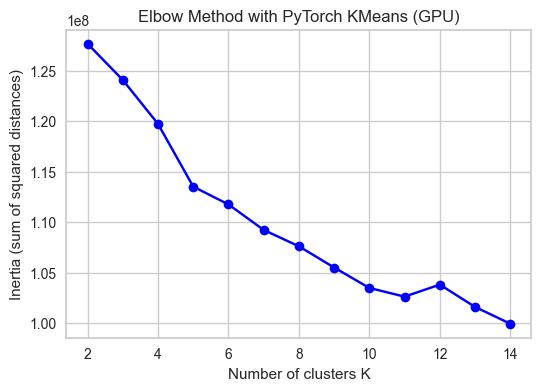

In [21]:
import torch
from kmeans_pytorch import kmeans
import matplotlib.pyplot as plt

# X_tensor should be your data tensor on GPU
# e.g., X_tensor = torch.tensor(X_scaled, dtype=torch.float32).cuda()

Ks = range(2,15 )   # Try k from 2 to 10
inertias = []

for k in Ks:
    # Run KMeans on GPU
    cluster_ids, cluster_centers = kmeans(
        X=X_tensor, 
        num_clusters=k, 
        distance='euclidean', 
        device=torch.device('cuda:0')
    )
    
    # Move cluster_centers to GPU if it's on CPU
    cluster_centers = cluster_centers.to(X_tensor.device)
    
    # Compute inertia manually: sum of squared distances to cluster center
    distances = torch.norm(X_tensor - cluster_centers[cluster_ids], dim=1) ** 2
    inertia = distances.sum().item()
    inertias.append(inertia)
    print(f"k={k}, inertia={inertia:.2f}")

# Plot Elbow
plt.figure(figsize=(6,4))
plt.plot(Ks, inertias, 'o-', color='blue')
plt.xlabel("Number of clusters K")
plt.ylabel("Inertia (sum of squared distances)")
plt.title("Elbow Method with PyTorch KMeans (GPU)")
plt.show()


In [22]:
# -----------------------------
# 7️⃣ Print the optimal number of clusters (from Elbow)
# -----------------------------
best_k = Ks[np.argmin(inertias)]  # Get the k with the lowest inertia
print(f"\n✅ Optimal number of clusters (Elbow): {best_k}")


✅ Optimal number of clusters (Elbow): 14


In [23]:
# -----------------------------
# 7️⃣ Run KMeans on GPU
# -----------------------------
num_clusters = 10
cluster_ids, cluster_centers = kmeans(
    X=X_tensor,
    num_clusters=num_clusters,
    distance='euclidean',
    device=torch.device('cuda:0')
)

print("Cluster IDs shape:", cluster_ids.shape)
print("Cluster centers shape:", cluster_centers.shape)

df_model_1['cluster1'] = cluster_ids
df_model_1['cluster1'].value_counts()



running k-means on cuda:0..


[running kmeans]: 39it [02:30,  3.86s/it, center_shift=0.000067, iteration=39, tol=0.000100]

Cluster IDs shape: torch.Size([64924])
Cluster centers shape: torch.Size([10, 7197])



C:\Users\arunkumara\AppData\Local\Temp\4\ipykernel_8132\1529915313.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_model_1['cluster1'] = cluster_ids


cluster1
1    15160
0    11073
7     9783
3     7123
2     6762
8     5831
9     4183
4     4085
6      879
5       45
Name: count, dtype: int64

### Predictive Model Cluster 3

In [86]:
# ---------------------------------------------------------------
# 1️⃣ Keep only your required columns
# ---------------------------------------------------------------
keep_cols = [
    "Payments", "LOS", "AGE", "IDSavings",
    "Provider_ID", "ADRG", "PRIM_DX", "B_DRG", "B_PRIMDX_Clean",
    "InitialDeterminationStatus",  "B_PRIM_DX_emb", "A_PRIM_DX_emb", 
    "A_DX_agg_emb", "B_DX_agg_emb",'cluster1'

]

df_model_final = df_model_1[keep_cols].copy()


In [88]:
df_model_final['cluster1'].value_counts()

cluster1
1    15160
0    11073
7     9783
3     7123
2     6762
8     5831
9     4183
4     4085
6      879
5       45
Name: count, dtype: int64

In [89]:
approval_counts = df_model_final.groupby(['cluster1', 'InitialDeterminationStatus']).size().unstack(fill_value=0)
print(approval_counts)


InitialDeterminationStatus  Approved  Denied
cluster1                                    
0                               9718    1355
1                              13908    1252
2                               6260     502
3                               4731    2392
4                               3677     408
5                                 35      10
6                                848      31
7                               8540    1243
8                               5146     685
9                               4043     140


In [98]:
df_cluster_3 = df_model_final[df_model_final['cluster1']==3].copy()
df_cluster_3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7123 entries, 20232 to 885965
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Payments                    7123 non-null   float64
 1   LOS                         7123 non-null   int64  
 2   AGE                         7123 non-null   int64  
 3   IDSavings                   7123 non-null   float64
 4   Provider_ID                 7123 non-null   object 
 5   ADRG                        7123 non-null   object 
 6   PRIM_DX                     7123 non-null   object 
 7   B_DRG                       7074 non-null   object 
 8   B_PRIMDX_Clean              7123 non-null   object 
 9   InitialDeterminationStatus  7123 non-null   object 
 10  B_PRIM_DX_emb               7123 non-null   object 
 11  A_PRIM_DX_emb               7123 non-null   object 
 12  A_DX_agg_emb                7123 non-null   object 
 13  B_DX_agg_emb                7123

In [104]:
from sklearn.feature_extraction import FeatureHasher

df_ml = df_cluster_3.copy()

df_ml["Status_binary"] = df_ml["InitialDeterminationStatus"].str.strip().str.lower().map({
    "approved": 1,
    "denied": 0
})
# ---------------------------------------------------
# 1. Numeric (dense)
# ---------------------------------------------------
num_features = ['Payments', 'AGE', 'LOS']
df_ml[num_features] = df_ml[num_features].apply(pd.to_numeric, errors='coerce').fillna(0.0)
X_num_dense = df_ml[num_features].astype('float32').values

# ---------------------------------------------------
# 2. Categorical (sparse hashing)
# ---------------------------------------------------
cat_features = ['ADRG',  'Provider_ID', ]

cat_rows = df_ml[cat_features].astype(str).values.tolist()

hasher = FeatureHasher(n_features=1000, input_type="string")
X_cat_sparse = hasher.transform(cat_rows)  # sparse

# ---------------------------------------------------
# 3. Embeddings (dense)
# ---------------------------------------------------
def fix_emb(col, dim=512):
    fixed = []
    for emb in col:
        arr = np.asarray(emb, dtype='float32')
        if arr.ndim != 1 or arr.shape[0] != dim:
            arr = np.zeros(dim, dtype='float32')
        fixed.append(arr)
    return np.vstack(fixed)

X_prim_dense = fix_emb(df_ml['A_PRIM_DX_emb'])
X_sdx_dense  = fix_emb(df_ml['A_DX_agg_emb'])

# Dense block
X_dense = np.hstack([X_num_dense, X_prim_dense, X_sdx_dense])

print("Sparse:", X_cat_sparse.shape)
print("Dense :", X_dense.shape)


Sparse: (7123, 1000)
Dense : (7123, 1027)


In [149]:
from scipy import sparse
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score,
    recall_score, f1_score, confusion_matrix, classification_report, precision_recall_curve,
)
import matplotlib.pyplot as plt
from lightgbm import early_stopping


# ---------------------------------------------------------
# 1. CLASS WEIGHT (to fix 70-30 imbalance)
# ---------------------------------------------------------
class_counts = df_ml['Status_binary'].value_counts()

class_weight = {
    0: 1.8,
    1: (class_counts[0] / class_counts[1]) - 0.08
}

df_ml['sample_weight'] = df_ml['Status_binary'].map(class_weight)

print("Class Weights:", class_weight)


# ---------------------------------------------------------
# 2. COMBINE BOTH WEIGHTS  (BEST METHOD)
# ---------------------------------------------------------
df_ml['final_weight'] = df_ml['sample_weight']

# -----------------------------
# 0. Combine features
# -----------------------------
X_dense_sparse = sparse.csr_matrix(X_dense)
X_full = sparse.hstack([X_dense_sparse, X_cat_sparse]).tocsr()

print("Full feature shape:", X_full.shape)

# ---------------------------------------------------------
# 3. TRAIN-TEST SPLIT  (use final_weight)
# ---------------------------------------------------------
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X_full,
    df_ml['Status_binary'],
    df_ml['final_weight'],         # combined weight
    test_size=0.2,
    random_state=42,
    stratify=df_ml['Status_binary']
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


# ---------------------------------------------------------
# 4. LIGHTGBM DATASETS
# ---------------------------------------------------------
train_data = lgb.Dataset(
    X_train,
    label=y_train,
    weight=w_train,
    free_raw_data=False
)

valid_data = lgb.Dataset(
    X_test,
    label=y_test,
    weight=w_test,
    free_raw_data=False
)

Class Weights: {0: 1.8, 1: np.float64(0.4256013527795392)}
Full feature shape: (7123, 2027)
Train size: (5698, 2027)
Test size: (1425, 2027)


In [150]:
params = {
    "objective": "binary",
    "boosting_type":"gbdt",
    "metric": "auc",
    "learning_rate": 0.02,
    "num_leaves": 28,
    "max_depth": 4,
    "colsample_bytree":0.8,
    "subsample":0.8,
    "reg_alpha":2,          # L1 regularization
    "reg_lambda":5,         # L2 regularization
    "min_child_samples":50, # Prevents small leaf overfit
    "random_state":42
  
}


model = lgb.train(
    params=params,
    train_set=train_data,
    valid_sets=[train_data, valid_data],
    valid_names=['train', 'valid'],
    num_boost_round=500,
    callbacks=[early_stopping(stopping_rounds=30)]

)


[LightGBM] [Info] Number of positive: 3785, number of negative: 1913
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.127381 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 174637
[LightGBM] [Info] Number of data points in the train set: 5698, number of used features: 1038
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.318719 -> initscore=-0.759666
[LightGBM] [Info] Start training from score -0.759666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh


🔹 Best Threshold: 0.2291
🔹 Best F1-score: 0.8234

--- MODEL PERFORMANCE (Optimized Threshold) ---
AUC:       0.8083
Accuracy:  0.7628
Precision: 0.8140
Recall:    0.8330
F1 Score:  0.8234

--- Classification Report (Optimized Threshold) ---
              precision    recall  f1-score   support

           0       0.65      0.62      0.64       479
           1       0.81      0.83      0.82       946

    accuracy                           0.76      1425
   macro avg       0.73      0.73      0.73      1425
weighted avg       0.76      0.76      0.76      1425



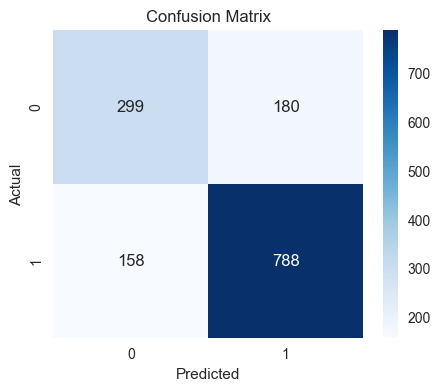

In [151]:
import seaborn as sns
# ---------------------------------------------------------
# 7. PREDICTIONS (probabilities only)
# ---------------------------------------------------------
y_prob = model.predict(X_test)


# ---------------------------------------------------------
# 8. FIND BEST THRESHOLD (based on F1-score)
# ---------------------------------------------------------
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)

best_thr = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

print("\n🔹 Best Threshold:", round(best_thr, 4))
print("🔹 Best F1-score:", round(best_f1, 4))


# ---------------------------------------------------------
# 9. FINAL PREDICTIONS USING BEST THRESHOLD
# ---------------------------------------------------------
y_pred = (y_prob >= best_thr).astype(int)


# ---------------------------------------------------------
# 10. METRICS (using optimized threshold)
# ---------------------------------------------------------
auc = roc_auc_score(y_test, y_prob)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\n--- MODEL PERFORMANCE (Optimized Threshold) ---")
print(f"AUC:       {auc:.4f}")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")

# ---------------------------------------------------------
# 13. CLASSIFICATION REPORT
# ---------------------------------------------------------
print("\n--- Classification Report (Optimized Threshold) ---")
print(classification_report(y_test, y_pred))

# ---------------------------------------------------------
# 11. CONFUSION MATRIX 
# ---------------------------------------------------------

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [152]:
 # Save original row indices for mapping later
train_idx = y_train.index
test_idx  = y_test.index  

# ---------------------------------------------------------
# 7. PREDICT PROBABILITY → CONFIDENCE
# ---------------------------------------------------------

# TRAIN
train_prob = model.predict(X_train)
train_conf = train_prob * 100
train_pred = (train_prob >= best_thr).astype(int)

df_train_pred = pd.DataFrame({
    "True_Label": y_train.values,
    "Pred_Label": train_pred,
    "Prob_Approved": train_prob,
    "Confidence_%": train_conf
}, index=train_idx)

# TEST
test_prob = model.predict(X_test)
test_conf = test_prob * 100
test_pred = (test_prob >= best_thr).astype(int)

df_test_pred = pd.DataFrame({
    "True_Label": y_test.values,
    "Pred_Label": test_pred,
    "Prob_Approved": test_prob,
    "Confidence_%": test_conf
}, index=test_idx)

# ---------------------------------------------------------
# 8. MAP BACK TO df_ml (NO NEED FOR ID COLUMN!)
# ---------------------------------------------------------

df_ml["Pred_Label"] = np.nan
df_ml["Prob_Approved"] = np.nan
df_ml["Confidence_%"] = np.nan

df_ml.loc[train_idx, ["Pred_Label", "Prob_Approved", "Confidence_%"]] = \
    df_train_pred[["Pred_Label", "Prob_Approved", "Confidence_%"]]

df_ml.loc[test_idx, ["Pred_Label", "Prob_Approved", "Confidence_%"]] = \
    df_test_pred[["Pred_Label", "Prob_Approved", "Confidence_%"]]

In [155]:
cols_to_drop = [
    'B_DRG', 'B_PRIMDX_Clean', 'B_PRIM_DX_emb', 'A_PRIM_DX_emb',
    'A_DX_agg_emb', 'B_DX_agg_emb'  ,"sample_weight","final_weight",'Prob_Approved'
]

df_ml1 = df_ml.drop(columns=cols_to_drop, errors='ignore')
df_ml1.head()

,Payments,LOS,AGE,IDSavings,Provider_ID,ADRG,PRIM_DX,InitialDeterminationStatus,cluster1,Status_binary,Pred_Label,Confidence_%
20232,5242.35,5,53,0.00,000021832C,871,A4151,Approved,3,1,1.0,79.594947
22677,14208.15,9,72,0.00,000069023E,871,A419,Approved,3,1,1.0,54.992109
33869,33038.49,8,63,0.00,560585243,853,A4102,Approved,3,1,1.0,44.352498
33872,14394.74,3,89,0.00,560562304,871,A4151,Approved,3,1,1.0,74.495030
33873,13057.77,18,75,1382.11,000076354B,871,A419,Denied,3,0,0.0,15.351691


# Cluster 

In [156]:
df_cluster_1 = df_model_final[df_model_final['cluster1']==1].copy()
df_cluster_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15160 entries, 1722 to 886028
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Payments                    15160 non-null  float64
 1   LOS                         15160 non-null  int64  
 2   AGE                         15160 non-null  int64  
 3   IDSavings                   15160 non-null  float64
 4   Provider_ID                 15160 non-null  object 
 5   ADRG                        15160 non-null  object 
 6   PRIM_DX                     15160 non-null  object 
 7   B_DRG                       15109 non-null  object 
 8   B_PRIMDX_Clean              15160 non-null  object 
 9   InitialDeterminationStatus  15160 non-null  object 
 10  B_PRIM_DX_emb               15160 non-null  object 
 11  A_PRIM_DX_emb               15160 non-null  object 
 12  A_DX_agg_emb                15160 non-null  object 
 13  B_DX_agg_emb                1516

In [157]:
from sklearn.feature_extraction import FeatureHasher

df_ml = df_cluster_1.copy()

df_ml["Status_binary"] = df_ml["InitialDeterminationStatus"].str.strip().str.lower().map({
    "approved": 1,
    "denied": 0
})
# ---------------------------------------------------
# 1. Numeric (dense)
# ---------------------------------------------------
num_features = ['Payments', 'AGE', 'LOS']
df_ml[num_features] = df_ml[num_features].apply(pd.to_numeric, errors='coerce').fillna(0.0)
X_num_dense = df_ml[num_features].astype('float32').values

# ---------------------------------------------------
# 2. Categorical (sparse hashing)
# ---------------------------------------------------
cat_features = ['ADRG',  'Provider_ID', ]

cat_rows = df_ml[cat_features].astype(str).values.tolist()

hasher = FeatureHasher(n_features=1000, input_type="string")
X_cat_sparse = hasher.transform(cat_rows)  # sparse

# ---------------------------------------------------
# 3. Embeddings (dense)
# ---------------------------------------------------
def fix_emb(col, dim=512):
    fixed = []
    for emb in col:
        arr = np.asarray(emb, dtype='float32')
        if arr.ndim != 1 or arr.shape[0] != dim:
            arr = np.zeros(dim, dtype='float32')
        fixed.append(arr)
    return np.vstack(fixed)

X_prim_dense = fix_emb(df_ml['A_PRIM_DX_emb'])
X_sdx_dense  = fix_emb(df_ml['A_DX_agg_emb'])

# Dense block
X_dense = np.hstack([X_num_dense, X_prim_dense, X_sdx_dense])

print("Sparse:", X_cat_sparse.shape)
print("Dense :", X_dense.shape)


Sparse: (15160, 1000)
Dense : (15160, 1027)


In [172]:
from scipy import sparse
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score,
    recall_score, f1_score, confusion_matrix, classification_report, precision_recall_curve,
)
import matplotlib.pyplot as plt
from lightgbm import early_stopping


# ---------------------------------------------------------
# 1. CLASS WEIGHT (to fix 70-30 imbalance)
# ---------------------------------------------------------
class_counts = df_ml['Status_binary'].value_counts()

class_weight = {
    0: 1,
    1: (class_counts[0] / class_counts[1]) 
}

df_ml['sample_weight'] = df_ml['Status_binary'].map(class_weight)

print("Class Weights:", class_weight)


# ---------------------------------------------------------
# 2. COMBINE BOTH WEIGHTS  (BEST METHOD)
# ---------------------------------------------------------
df_ml['final_weight'] = df_ml['sample_weight']

# -----------------------------
# 0. Combine features
# -----------------------------
X_dense_sparse = sparse.csr_matrix(X_dense)
X_full = sparse.hstack([X_dense_sparse, X_cat_sparse]).tocsr()

print("Full feature shape:", X_full.shape)

# ---------------------------------------------------------
# 3. TRAIN-TEST SPLIT  (use final_weight)
# ---------------------------------------------------------
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X_full,
    df_ml['Status_binary'],
    df_ml['final_weight'],         # combined weight
    test_size=0.2,
    random_state=42,
    stratify=df_ml['Status_binary']
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


# ---------------------------------------------------------
# 4. LIGHTGBM DATASETS
# ---------------------------------------------------------
train_data = lgb.Dataset(
    X_train,
    label=y_train,
    weight=w_train,
    free_raw_data=False
)

valid_data = lgb.Dataset(
    X_test,
    label=y_test,
    weight=w_test,
    free_raw_data=False
)

Class Weights: {0: 1.43896, 1: np.float64(0.09002013229795801)}
Full feature shape: (15160, 2027)
Train size: (12128, 2027)
Test size: (3032, 2027)


In [203]:
params = {
    "objective": "binary",
    "boosting_type": "gbdt",
    "metric": "auc",

    # Reduce complexity
    "num_leaves": 32,
    "max_depth": 6,


    "min_data_in_leaf": 40,


    "learning_rate": 0.04,

    # Handle class imbalance
    "is_unbalance": True,

    # Limit trees
    "n_estimators": 700,

    "colsample_bytree":0.8,
    "subsample":0.8,
    "reg_alpha":2,          # L1 regularization
    "reg_lambda":5,         # L2 regularization
    "min_child_samples":40, # Prevents small leaf overfit
    "random_state":42
}



model = lgb.train(
    params=params,
    train_set=train_data,
    valid_sets=[train_data, valid_data],
    valid_names=['train', 'valid'],
    num_boost_round=500,
    callbacks=[early_stopping(stopping_rounds=30)]

)


[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.8 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=2 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=5 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.8 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=2 will be ignored. Current v


🔹 Best Threshold: 0.0242
🔹 Best F1-score: 0.9601

--- MODEL PERFORMANCE (Optimized Threshold) ---
AUC:       0.8414
Accuracy:  0.9258
Precision: 0.9475
Recall:    0.9730
F1 Score:  0.9601

--- Classification Report (Optimized Threshold) ---
              precision    recall  f1-score   support

           0       0.57      0.40      0.47       250
           1       0.95      0.97      0.96      2782

    accuracy                           0.93      3032
   macro avg       0.76      0.69      0.72      3032
weighted avg       0.92      0.93      0.92      3032



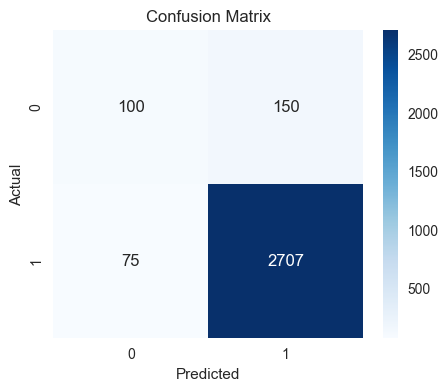

In [204]:
import seaborn as sns
# ---------------------------------------------------------
# 7. PREDICTIONS (probabilities only)
# ---------------------------------------------------------
y_prob = model.predict(X_test)


# ---------------------------------------------------------
# 8. FIND BEST THRESHOLD (based on F1-score)
# ---------------------------------------------------------
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)

best_thr = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

print("\n🔹 Best Threshold:", round(best_thr, 4))
print("🔹 Best F1-score:", round(best_f1, 4))


# ---------------------------------------------------------
# 9. FINAL PREDICTIONS USING BEST THRESHOLD
# ---------------------------------------------------------
y_pred = (y_prob >= best_thr).astype(int)


# ---------------------------------------------------------
# 10. METRICS (using optimized threshold)
# ---------------------------------------------------------
auc = roc_auc_score(y_test, y_prob)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\n--- MODEL PERFORMANCE (Optimized Threshold) ---")
print(f"AUC:       {auc:.4f}")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")

# ---------------------------------------------------------
# 13. CLASSIFICATION REPORT
# ---------------------------------------------------------
print("\n--- Classification Report (Optimized Threshold) ---")
print(classification_report(y_test, y_pred))

# ---------------------------------------------------------
# 11. CONFUSION MATRIX 
# ---------------------------------------------------------

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Cluster Analysis

In [ ]:
# ---------------------------------------------------------------
# 1️⃣ Keep only your required columns
# ---------------------------------------------------------------
keep_cols = [
     "Provider_ID", "LOS", "AGE","Payments", "InitialDeterminationStatus", "IDSavings",
    "ADRG","B_DRG","PRIM_DX", "B_PRIMDX_Clean","A_DX_Set","A_DX_Type","B_DX_Set",
    "B_DX_Type","DRG_Change_Status","Prim_DX_Change_Status",
      "SDX_Set_Change_Status","SDX_Type_ChangeStatus","cluster"

]

df_model_1_final = df3[keep_cols].copy()


In [28]:
df_model_1_final.head()

,Payments,LOS,AGE,IDSavings,Provider_ID,ADRG,PRIM_DX,B_DRG,B_PRIMDX_Clean,InitialDeterminationStatus,Prim_DX_Change_Status,SDX_Type_ChangeStatus,DRG_Change_Status,SDX_Set_Change_Status,cluster1
1719,4277.47,6,60,0.0,593458145N,8613,G893,8613,G893,Approved,No Change,No Change,No Change,No Change,0
1720,9642.73,8,40,0.0,592616017M,6953,Z5111,6953,Z5111,Approved,No Change,No Change,No Change,No Change,0
1721,7815.43,9,76,0.0,000045770H,189,J9601,189,J9601,Approved,No Change,No Change,No Change,No Change,7
1722,15539.61,16,63,0.0,001825011C,539,M4626,539,M4626,Approved,No Change,No Change,No Change,No Change,1
1723,9020.75,7,79,0.0,381428164,682,I120,682,I120,Approved,No Change,No Change,No Change,No Change,9


In [33]:
approval_counts = df_model_1_final.groupby(['cluster1', 'InitialDeterminationStatus']).size().unstack(fill_value=0)
print(approval_counts)


InitialDeterminationStatus  Approved  Denied
cluster1                                    
0                               9718    1355
1                              13908    1252
2                               6260     502
3                               4731    2392
4                               3677     408
5                                 35      10
6                                848      31
7                               8540    1243
8                               5146     685
9                               4043     140


In [68]:
df_model_1_final.head()

,Payments,LOS,AGE,IDSavings,Provider_ID,ADRG,PRIM_DX,B_DRG,B_PRIMDX_Clean,InitialDeterminationStatus,Prim_DX_Change_Status,SDX_Type_ChangeStatus,DRG_Change_Status,SDX_Set_Change_Status,cluster1
1719,4277.47,6,60,0.0,593458145N,8613,G893,8613,G893,Approved,No Change,No Change,No Change,No Change,0
1720,9642.73,8,40,0.0,592616017M,6953,Z5111,6953,Z5111,Approved,No Change,No Change,No Change,No Change,0
1721,7815.43,9,76,0.0,000045770H,189,J9601,189,J9601,Approved,No Change,No Change,No Change,No Change,7
1722,15539.61,16,63,0.0,001825011C,539,M4626,539,M4626,Approved,No Change,No Change,No Change,No Change,1
1723,9020.75,7,79,0.0,381428164,682,I120,682,I120,Approved,No Change,No Change,No Change,No Change,9


In [73]:
df_F = df_model_1_final[df_model_1_final['cluster1']==7].copy()
df_F.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9783 entries, 1721 to 886018
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Payments                    9783 non-null   float64
 1   LOS                         9783 non-null   int64  
 2   AGE                         9783 non-null   int64  
 3   IDSavings                   9783 non-null   float64
 4   Provider_ID                 9783 non-null   object 
 5   ADRG                        9783 non-null   object 
 6   PRIM_DX                     9783 non-null   object 
 7   B_DRG                       9764 non-null   object 
 8   B_PRIMDX_Clean              9783 non-null   object 
 9   InitialDeterminationStatus  9783 non-null   object 
 10  Prim_DX_Change_Status       9783 non-null   object 
 11  SDX_Type_ChangeStatus       9783 non-null   object 
 12  DRG_Change_Status           9783 non-null   object 
 13  SDX_Set_Change_Status       9783 

In [74]:
# Group by 'PRIM_DX' and 'InitialDeterminationStatus', count the occurrences, unstack, and sort by the sum of each row
approval_counts = df_F.groupby(['PRIM_DX', 'InitialDeterminationStatus']).size().unstack(fill_value=0)

# Sort rows by the sum of each row (i.e., total count) in descending order
approval_counts['total'] = approval_counts.sum(axis=1)  # Add a 'total' column for sorting
approval_counts = approval_counts.sort_values(by='total', ascending=False).drop(columns='total')

# Display the sorted result
print(approval_counts)


InitialDeterminationStatus  Approved  Denied
PRIM_DX                                     
J441                            1701     278
J9621                            798     179
J189                             513      89
J9601                            402     135
U071                             210      28
J440                             196      13
I214                             138       9
J9622                            126      12
I2699                            125      12
J159                             100      16
A419                              35      76
N179                              84       9
J9602                             72       7
I2609                             65       2
J9383                             60       4
J690                              44      18
J1000                             46      12
J1008                             48       8
J810                              53       0
S72141A                           46       3
J90       

In [75]:
# Group by 'PRIM_DX' and 'InitialDeterminationStatus', count the occurrences, unstack, and sort by the sum of each row
approval_counts = df_F.groupby(['ADRG', 'InitialDeterminationStatus']).size().unstack(fill_value=0)

# Sort rows by the sum of each row (i.e., total count) in descending order
approval_counts['total'] = approval_counts.sum(axis=1)  # Add a 'total' column for sorting
approval_counts = approval_counts.sort_values(by='total', ascending=False).drop(columns='total')

# Display the sorted result
print(approval_counts)


InitialDeterminationStatus  Approved  Denied
ADRG                                        
190                             1633     296
189                             1443     335
193                              806     163
177                              262      57
191                              274       1
175                              251      21
871                               76     141
377                              210       4
199                              188      15
064                              191       5
480                              167      10
163                              102       6
682                               94      10
280                               83       9
194                               90       0
308                               85       3
183                               73       7
329                               74       4
023                               72       4
917                               64       5
602       

In [ ]:
# Filter rows for Denial claims
denied_claims = df_F[df_F['InitialDeterminationStatus'] == 'Denied']

# Group by 'PRIM_DX' and calculate summary statistics (mean, median, etc.)
denied_claims_grouped = denied_claims.groupby('PRIM_DX')[['Payments', 'LOS', 'AGE', 'IDSavings']].describe()
denied_claims_grouped


In [62]:
df_F1 = df_model_1_final[df_model_1_final['cluster1']==1].copy()
df_F1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15160 entries, 1722 to 886028
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Payments                    15160 non-null  float64
 1   LOS                         15160 non-null  int64  
 2   AGE                         15160 non-null  int64  
 3   IDSavings                   15160 non-null  float64
 4   Provider_ID                 15160 non-null  object 
 5   ADRG                        15160 non-null  object 
 6   PRIM_DX                     15160 non-null  object 
 7   B_DRG                       15109 non-null  object 
 8   B_PRIMDX_Clean              15160 non-null  object 
 9   InitialDeterminationStatus  15160 non-null  object 
 10  Prim_DX_Change_Status       15160 non-null  object 
 11  SDX_Type_ChangeStatus       15160 non-null  object 
 12  DRG_Change_Status           15160 non-null  object 
 13  SDX_Set_Change_Status       1516

In [63]:
# Group by 'PRIM_DX' and 'InitialDeterminationStatus', count the occurrences, unstack, and sort by the sum of each row
approval_counts = df_F1.groupby(['PRIM_DX', 'InitialDeterminationStatus']).size().unstack(fill_value=0)

# Sort rows by the sum of each row (i.e., total count) in descending order
approval_counts['total'] = approval_counts.sum(axis=1)  # Add a 'total' column for sorting
approval_counts = approval_counts.sort_values(by='total', ascending=False).drop(columns='total')

# Display the sorted result
print(approval_counts)


InitialDeterminationStatus  Approved  Denied
PRIM_DX                                     
N179                            2556     231
J9601                            245     183
K56609                           353      12
K56600                           287       7
G9341                            202      66
E222                             222      13
I214                             224       8
J9621                            164      62
J189                             179      10
N170                             152       6
K5650                            144       4
J441                             123       4
I639                             124       2
I674                             121       4
N390                              92      13
K5651                             96       2
E1110                             92       6
C182                              97       0
U071                              88       2
K31811                            86       3
K254      

In [64]:
# Group by 'PRIM_DX' and 'InitialDeterminationStatus', count the occurrences, unstack, and sort by the sum of each row
approval_counts = df_F1.groupby(['ADRG', 'InitialDeterminationStatus']).size().unstack(fill_value=0)

# Sort rows by the sum of each row (i.e., total count) in descending order
approval_counts['total'] = approval_counts.sum(axis=1)  # Add a 'total' column for sorting
approval_counts = approval_counts.sort_values(by='total', ascending=False).drop(columns='total')

# Display the sorted result
print(approval_counts)


InitialDeterminationStatus  Approved  Denied
ADRG                                        
683                             2520     206
389                              768      20
189                              437     252
330                              525       3
377                              381      29
071                              303      69
378                              306       3
064                              282      16
644                              230      15
682                              175      30
281                              169       7
194                              170       5
698                              120      54
872                               83      84
329                              154       5
065                              140       4
480                              116      24
919                              131       5
398                              124       4
809                              125       3
078       

In [65]:
df_F2 = df_model_1_final[df_model_1_final['cluster1']==0].copy()
df_F2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11073 entries, 1719 to 886078
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Payments                    11073 non-null  float64
 1   LOS                         11073 non-null  int64  
 2   AGE                         11073 non-null  int64  
 3   IDSavings                   11073 non-null  float64
 4   Provider_ID                 11073 non-null  object 
 5   ADRG                        11073 non-null  object 
 6   PRIM_DX                     11073 non-null  object 
 7   B_DRG                       11028 non-null  object 
 8   B_PRIMDX_Clean              11073 non-null  object 
 9   InitialDeterminationStatus  11073 non-null  object 
 10  Prim_DX_Change_Status       11073 non-null  object 
 11  SDX_Type_ChangeStatus       11073 non-null  object 
 12  DRG_Change_Status           11073 non-null  object 
 13  SDX_Set_Change_Status       1107

In [66]:
# Group by 'PRIM_DX' and 'InitialDeterminationStatus', count the occurrences, unstack, and sort by the sum of each row
approval_counts = df_F2.groupby(['PRIM_DX', 'InitialDeterminationStatus']).size().unstack(fill_value=0)

# Sort rows by the sum of each row (i.e., total count) in descending order
approval_counts['total'] = approval_counts.sum(axis=1)  # Add a 'total' column for sorting
approval_counts = approval_counts.sort_values(by='total', ascending=False).drop(columns='total')

# Display the sorted result
print(approval_counts)


InitialDeterminationStatus  Approved  Denied
PRIM_DX                                     
I110                            1241      29
I480                             459      31
R0789                            384       3
I4891                            299      15
I350                             260       7
K7031                            228       9
N179                              23     201
R079                             220       2
J9601                              4     204
E1169                            178      13
A419                              15     156
I2510                            159       9
K7460                            157      10
J439                             143      20
I495                             135       3
I6521                            123       5
J101                             110      13
J9621                              8     110
I6523                            116       1
E11649                           103      14
I6522     

In [67]:
# Group by 'PRIM_DX' and 'InitialDeterminationStatus', count the occurrences, unstack, and sort by the sum of each row
approval_counts = df_F2.groupby(['ADRG', 'InitialDeterminationStatus']).size().unstack(fill_value=0)

# Sort rows by the sum of each row (i.e., total count) in descending order
approval_counts['total'] = approval_counts.sum(axis=1)  # Add a 'total' column for sorting
approval_counts = approval_counts.sort_values(by='total', ascending=False).drop(columns='total')

# Display the sorted result
print(approval_counts)


InitialDeterminationStatus  Approved  Denied
ADRG                                        
308                              685      38
291                              667      17
313                              546       4
432                              523      24
189                               14     325
391                              297      18
280                              280      21
266                              273       8
637                              238      25
683                               55     195
640                              215      13
286                              216       6
190                              153      29
038                              173       3
242                              152       3
035                              146       5
235                              131       8
100                              117      17
809                              117       3
441                              112       8
641       

In [38]:
cols = ["Prim_DX_Change_Status", "SDX_Type_ChangeStatus", "DRG_Change_Status","SDX_Set_Change_Status"]

# Keep rows where all columns are "No Change"
df3 = df_model_1_final[(df_model_1_final[cols] == "No Change").all(axis=1)].copy()
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55902 entries, 1719 to 886078
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Payments                    55902 non-null  float64
 1   LOS                         55902 non-null  int64  
 2   AGE                         55902 non-null  int64  
 3   IDSavings                   55902 non-null  float64
 4   Provider_ID                 55902 non-null  object 
 5   ADRG                        55902 non-null  object 
 6   PRIM_DX                     55902 non-null  object 
 7   B_DRG                       55902 non-null  object 
 8   B_PRIMDX_Clean              55902 non-null  object 
 9   InitialDeterminationStatus  55902 non-null  object 
 10  Prim_DX_Change_Status       55902 non-null  object 
 11  SDX_Type_ChangeStatus       55902 non-null  object 
 12  DRG_Change_Status           55902 non-null  object 
 13  SDX_Set_Change_Status       5590

In [58]:
approval_counts = df3.groupby(['cluster1', 'InitialDeterminationStatus']).size().unstack(fill_value=0)
print(approval_counts)


InitialDeterminationStatus  Approved  Denied
cluster1                                    
0                               9627       0
1                              13620       0
2                               6213       1
3                               4410       0
4                               3643       0
5                                 34       0
6                                838       0
7                               8417       0
8                               5080       0
9                               4018       1


In [42]:
cols = ["Prim_DX_Change_Status", "SDX_Type_ChangeStatus", "DRG_Change_Status","SDX_Set_Change_Status"]

# Keep rows where all columns are "No Change"
df5 = df_model_1_final[~(df_model_1_final[cols] == "No Change").all(axis=1)].copy()
df5.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9022 entries, 33870 to 886028
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Payments                    9022 non-null   float64
 1   LOS                         9022 non-null   int64  
 2   AGE                         9022 non-null   int64  
 3   IDSavings                   9022 non-null   float64
 4   Provider_ID                 9022 non-null   object 
 5   ADRG                        9022 non-null   object 
 6   PRIM_DX                     9022 non-null   object 
 7   B_DRG                       8803 non-null   object 
 8   B_PRIMDX_Clean              9022 non-null   object 
 9   InitialDeterminationStatus  9022 non-null   object 
 10  Prim_DX_Change_Status       9022 non-null   object 
 11  SDX_Type_ChangeStatus       9022 non-null   object 
 12  DRG_Change_Status           9022 non-null   object 
 13  SDX_Set_Change_Status       9022

In [43]:
approval_counts = df5.groupby(['cluster1', 'InitialDeterminationStatus']).size().unstack(fill_value=0)
print(approval_counts)


InitialDeterminationStatus  Approved  Denied
cluster1                                    
0                                 91    1355
1                                288    1252
2                                 47     501
3                                321    2392
4                                 34     408
5                                  1      10
6                                 10      31
7                                123    1243
8                                 66     685
9                                 25     139


In [44]:
df6 = df5[df5['cluster1']==3].copy()

In [46]:
df7 = df6[df6['InitialDeterminationStatus']=='Approved'].copy()

In [47]:
df7['combined_column'] = df7[["Prim_DX_Change_Status", "SDX_Type_ChangeStatus", "DRG_Change_Status","SDX_Set_Change_Status"]].astype(str).agg('|'.join, axis=1)
# Compute value counts
df7['combined_column'].value_counts(ascending=False).head(50)

combined_column
Change|No Change|Change|Change          253
No Change|No Change|Change|No Change     48
Change|No Change|No Change|Change         5
Change|Change|Change|Change               5
No Change|No Change|No Change|Change      4
No Change|Change|Change|Change            4
Change|Change|No Change|Change            1
No Change|Change|No Change|Change         1
Name: count, dtype: int64

In [48]:
df8 = df6[df6['InitialDeterminationStatus']=='Denied'].copy()
df8.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2392 entries, 33873 to 885965
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Payments                    2392 non-null   float64
 1   LOS                         2392 non-null   int64  
 2   AGE                         2392 non-null   int64  
 3   IDSavings                   2392 non-null   float64
 4   Provider_ID                 2392 non-null   object 
 5   ADRG                        2392 non-null   object 
 6   PRIM_DX                     2392 non-null   object 
 7   B_DRG                       2392 non-null   object 
 8   B_PRIMDX_Clean              2392 non-null   object 
 9   InitialDeterminationStatus  2392 non-null   object 
 10  Prim_DX_Change_Status       2392 non-null   object 
 11  SDX_Type_ChangeStatus       2392 non-null   object 
 12  DRG_Change_Status           2392 non-null   object 
 13  SDX_Set_Change_Status       2392

In [50]:
df8[df8['DRG_Change_Status']=='No Change'].head()

,Payments,LOS,AGE,IDSavings,Provider_ID,ADRG,PRIM_DX,B_DRG,B_PRIMDX_Clean,InitialDeterminationStatus,Prim_DX_Change_Status,SDX_Type_ChangeStatus,DRG_Change_Status,SDX_Set_Change_Status,cluster1,combined_column
768353,11951.08,6,71,7011.11,550261260U,698,T83511A,698,T83511A,Denied,No Change,No Change,No Change,Change,3,No Change|No Change|No Change|Change


In [51]:
df8['Prim_DX_Change_Status'].value_counts(ascending=False).head(10)

Prim_DX_Change_Status
Change       2174
No Change     218
Name: count, dtype: int64

In [52]:
df8['PRIM_DX'].value_counts(ascending=False).head(10)

PRIM_DX
A419     1587
A4151     149
A4189     121
A4159      59
A4101      43
A4102      40
J189       36
A4150      29
A403       24
A4181      23
Name: count, dtype: int64

In [53]:
df8['ADRG'].value_counts(ascending=False).head(10)

ADRG
871     1430
872      363
853      279
698       59
854       56
193       36
862       25
314       18
856       17
7204      16
Name: count, dtype: int64

# Using PCA

In [12]:
# Convert list column → 2D numpy array (N × 512)
X = np.vstack(union_df['embedding'].values)
pca = PCA(n_components=0.95, random_state=42)

X_reduced = pca.fit_transform(X)
union_df['embedding_reduced'] = list(X_reduced)

print("Original dimension:", X.shape[1])
print("Reduced dimension:", X_reduced.shape[1])
print("Explained variance:", sum(pca.explained_variance_ratio_))

Original dimension: 512
Reduced dimension: 280
Explained variance: 0.950110768936314


In [15]:
union_df.head(1)

,Unique_ICD,id,embedding,embedding_reduced
0,A020,A020,"[0.056815307587385004, -0.046429712325334, 0.017006859183311, 0.021723499521613003, -0.028012353926897004, 0.018390407785773, 0.048837445676326, -0.012074599973857, -0.007919464260339001, 0.025011671707034003, 0.047543738037347, 0.031444270163774005, -0.030240405350923004, 0.008548350073397, 0.005107447970658, -0.019603257998824, 0.039062768220901004, -0.051209241151809005, -0.09645305573940201, 0.10040605068206701, 0.047256249934434, 0.0055476678535340005, 0.008148558437824001, -0.042656399309635, 0.014706934802234001, 0.016539687290787003, -0.018848594278097, 0.038379978388547, 0.00071367266355, -0.06414631754159901, 0.064757235348224, -0.033061407506465, -0.007339991629123001, -0.02247816324234, -0.036026149988174, 0.037697188556194, 0.05742622539401, -0.007268118672072001, -0.089337669312953, 0.050634261220693005, 0.014482333324849002, -0.012946056202054001, 0.020106365904211002, 0.09329066425561901, 0.036115992814302, -0.0032387599349020003, -0.075538128614425, -0.044237598776817, 0.060983918607234004, -0.012101552449166001, 0.09415313601493801, 0.006962660234421001, 0.056240327656269004, -0.00047362933401000004, -0.016728352755308002, -0.053724784404039, -0.004370753653347, 0.076544344425201, -0.044345408678054005, -0.08121605962514801, 0.039925239980220004, -0.054443512111902, -0.052395142614841, -0.063786953687667, 0.054731000214815, -0.047292184084653, 0.000883247121237, 0.045675050467252, 0.056240327656269004, 0.007492720615118, -0.060696430504322, -0.062672927975654, -0.006023824214935001, -0.016036579385399, 0.09350628405809401, 0.008144066669046001, -0.007501705083996, -0.09350628405809401, 0.016198292374610002, 0.030761482194066003, 0.017438095062971, 0.023394538089632003, 0.025532748550176003, -0.07632872462272601, 0.005399430636316, 0.021921150386333, -0.059941764920949006, -0.030294310301542, 0.00014472787734100002, 0.041111137717962, -0.023358602076768, 0.047220312058925004, -0.014374524354934002, -0.042800147086381, 0.070219554007053, -0.0040091448463490005, 0.039350260049104004, -0.049699917435646, -0.054120082408189, -0.006562868598848, ...]","[0.12611744372839348, 0.09922941541416691, -0.15749628725464276, 0.01234012479772656, -0.13264087259724372, 0.026153554924195153, -0.0602020257378031, 0.0806473404517386, -0.12019768491855368, 0.15395409913503794, 0.10509786359620299, -0.09851751918379877, -0.06389287034118678, 0.3290483293357107, 0.05274002721572156, 0.08218719538457661, -0.09195116029115105, 0.11907927301235789, -0.006110162509722336, 0.05599982830074595, -0.0555397949286832, 0.10852566482850545, 0.0052441964570537625, -0.09836678438691442, -0.16351878083086885, -0.008709305237768488, 0.032301450510869266, 0.15334117555599813, 0.024057199061671128, 0.02910615374714484, 0.03243050969912945, -0.014278907922722465, 0.0030098972875292618, -0.017538121767095363, -0.060534474312607583, -0.06728644177230118, 0.11878723865678546, -0.017049907488374386, -0.0065895584976042795, 0.032936813042697785, 0.014749067611488142, -0.07683740413526194, -0.007857812851017887, 0.03872542606656827, 0.06448548773937526, 0.010806123323731404, 0.022912072988794635, -0.010894441291958434, 0.07808772955555644, 0.04661515195902977, -0.039925747122254565, -0.014920988761014331, -0.04533637063166906, -0.020331922631062732, 0.05940444200868947, 0.0883838311261576, 0.01755027838655882, -0.018170741437630058, 0.07803900788614451, 0.04026906603301527, -0.030473626123159167, 0.06833959496953708, 0.06351322992678796, -0.09263800281590764, 0.035474181851051105, 0.06929645941117642, -0.02071679273583407, 0.0002742949433351613, -0.017695703154365278, -0.10124016202316503, 0.04691483194654161, 0.00036672810134853046, 0.01902965186468141, 0.07634344191382939, 0.0212435365288029, 0.036706539039172, -0.08158465027109875, -0.058181338405266264, -0.042037061337528256, -0.06931535791929185, -0.0358369220102703, -0.043359293560049125, -0.11221085095967334, -0.0398251967663764, 0.04108781464

In [13]:
# Ensure embeddings are np.array type
union_df['embedding_reduced'] = union_df['embedding_reduced'].apply(np.array)

# Create ICD → embedding dictionary
icd_to_emb = dict(zip(union_df['Unique_ICD'], union_df['embedding_reduced']))

In [14]:
# ---------------------------------------
# Helper: return embedding or zero vector
# ---------------------------------------
def get_embedding(code, icd_to_emb, embedding_dim=280):
    if code in icd_to_emb:
        return icd_to_emb[code]
    else:
        return np.zeros(embedding_dim)

# ---------------------------------------
# Map SDX list → list of embeddings
# ---------------------------------------
def map_icd_embeddings(icd_list, icd_to_emb, embedding_dim=280):
    # Convert tuple → list
    icd_list = list(icd_list)

    # Return list of embeddings (each 512-dim)
    return [
        get_embedding(c, icd_to_emb, embedding_dim)
        for c in icd_list
    ]

embedding_dim = 280

# ---------------------------------------
# Apply to dataframe
# ---------------------------------------
df2['A_DX_Set_embeddings'] = df2['A_DX_Set'].apply(
    lambda codes: map_icd_embeddings(codes, icd_to_emb, embedding_dim)
)

df2['B_DX_Set_embeddings'] = df2['B_DX_Set'].apply(
    lambda codes: map_icd_embeddings(codes, icd_to_emb, embedding_dim)
)

df2['A_PRIM_DX_emb'] = df2['PRIM_DX'].apply(
    lambda code: get_embedding(code, icd_to_emb, embedding_dim)
)

df2['B_PRIM_DX_emb'] = df2['B_PRIMDX_Clean'].apply(
    lambda code: get_embedding(code, icd_to_emb, embedding_dim)
)

print(df2.info())
df2.head(1)


<class 'pandas.core.frame.DataFrame'>
Index: 64924 entries, 1719 to 886078
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Client                      64924 non-null  object 
 1   PaymentType                 64924 non-null  object 
 2   Payments                    64924 non-null  float64
 3   Provider_ID                 64924 non-null  object 
 4   HospitalName                64924 non-null  object 
 5   LOS                         64924 non-null  int64  
 6   ADRG                        64924 non-null  object 
 7   AGE                         64924 non-null  int64  
 8   PRIM_DX                     64924 non-null  object 
 9   B_DRG                       64705 non-null  object 
 10  InitialDeterminationStatus  64924 non-null  object 
 11  IDSavings                   64924 non-null  float64
 12  B_PRIMDX_Clean              64924 non-null  object 
 13  A_DX_Type                   6492

,Client,PaymentType,Payments,Provider_ID,HospitalName,LOS,ADRG,AGE,PRIM_DX,B_DRG,InitialDeterminationStatus,IDSavings,B_PRIMDX_Clean,A_DX_Type,A_DX_Set,B_DX_Type,B_DX_Set,A_DX_Count,B_DX_Count,DX_Change_Status,DX_Type_Status,DRG_Status,DX_Set_Change_Status,A_DX_Set_embeddings,B_DX_Set_embeddings,A_PRIM_DX_emb,B_PRIM_DX_emb
1719,Hum,postpay,4277.47,593458145N,TAMPA GENERAL HOSPITAL,6,8613,60,G893,8613,Approved,0.0,G893,MCC,"(A419,)",MCC,"(A419,)",1,1,No Change,No Change,No Change,No Change,"[[0.16569679033115892, -0.039206085117768075, 0.08954628939045, 0.10091067209829553, -0.3157440804469188, 0.03657510507573444, -0.1192335599958478, 0.14578414705543907, 0.18258399713826778, 0.1717902831528279, 0.1049058327885923, -0.1415799049409754, 0.112822765095283, 0.1167736356292747, -0.07625750244781654, 0.14464887955561184, -0.05662755973388733, 0.09368803886919005, -0.0628857420866551, 0.11511739170973893, -0.0851121700835701, 0.07779478227699033, -0.022197435626562678, 0.010196557278779675, -0.049400748112190564, -0.08151490482782042, 0.06347520409428398, 0.03533288014744533, -0.05041859313471908, 0.05279307185410093, 0.06760888410385481, 0.00046040654690446617, -0.06974655616641859, -0.06967367892827513, -0.003932589601591636, 0.03693033599611374, -0.004727427020787642, -0.04193008967471418, 0.03713580356909471, 0.06370420398400999, 0.03760215551341113, 0.030969495531603566, 0.04152574711322454, 0.034932132251953935, -0.059137487587974547, 0.09654889791057181, 0.05871985133931966, 0.0032911528383288285, -0.009883969296211423, 0.12034370186281795, -0.024796401793780627, 0.047204433376467854, 0.03792394468448021, 0.013727927356458593, 0.004789104621869475, 0.007104577235665585, -0.051940218076434445, -0.029936520969075973, -0.014932680341251416, -0.030544347560975134, -0.043098912084765115, 0.030011750114184742, -0.04167174051778981, -0.013650563197226274, -0.1061263010472949, -0.0070133365753289045, -0.07390227361208133, 0.0736666225881995, -0.03263671294784466, -0.008594359567440573, 0.01404073400030989, -0.010064420622036559, -0.04439674536101145, -0.057540018944721175, -0.01390200713893617, -0.012748350137584852, -0.027862541644919157, 0.0012228690446519017, -0.0019625887937570266, 0.02235011356121093, 0.006206638413840931, -0.055087908197839514, -0.010028295818240086, 0.057466038523623586, -0.003322476943718067, 0.03227711216573491, 0.0481684330854123, -0.022499274127495958, 0.025908410357284563, 0.05162959027396808, 0.02415678034176852, 0.060981212090420706, -0.028844512132408857, 0.028167416290998566, -0.026107746373130757, -0.05941765786945509, -0.01838353990486149, -0.006068064491497492, 0.012829843349199573, 0.021404462771666022, ...]]","[[0.16569679033115892, -0.039206085117768075, 0.08954628939045, 0.10091067209829553, -0.3157440804469188, 0.03657510507573444, -0.1192335599958478, 0.14578414705543907, 0.18258399713826778, 0.1717902831528279, 0.1049058327885923, -0.1415799049409754, 0.112822765095283, 0.1167736356292747, -0.07625750244781654, 0.14464887955561184, -0.05662755973388733, 0.09368803886919005, -0.0628857420866551, 0.11511739170973893, -0.0851121700835701, 0.07779478227699033, -0.022197435626562678, 0.010196557278779675, -0.049400748112190564, -0.08151490482782042, 0.06347520409428398, 0.03533288014744533, -0.05041859313471908, 0.05279307185410093, 0.06760888410385481, 0.00046040654690446617, -0.06974655616641859, -0.06967367892827513, -0.003932589601591636, 0.03693033599611374, -0.004727427020787642, -0.04193008967471418, 0.03713580356909471, 0.06370420398400999, 0.03760215551341113, 0.030969495531603566, 0.04152574711322454, 0.034932132251953935, -0.059137487587974547, 0.09654889791057181, 0.05871985133931966, 0.0032911528383288285, -0.009883969296211423, 0.12034370186281795, -0.024796401793780627, 0.047204433376467854, 0.03792394468448021, 0.013727927356458593, 0.004789104621869475, 0.007104577235665585, -0.051940218076434445, -0.029936520969075973, -0.014932680341251416, -0.030544347560975134, -0.04309891208

In [15]:
class QueryAttentionPooling(nn.Module):
    def __init__(self, embedding_dim=280):
        super().__init__()
        self.query = nn.Parameter(torch.randn(embedding_dim))

    def forward(self, x):
        """
        x: tensor shape (N_codes, embedding_dim)
        returns: pooled vector (embedding_dim,)
        """
        if x.ndim == 1:
            return x

        q = F.normalize(self.query, dim=0)   # (D,)
        x_norm = F.normalize(x, dim=1)       # (N, D)

        scores = torch.matmul(x_norm, q)      # (N,)
        weights = F.softmax(scores, dim=0)    # (N,)

        pooled = torch.sum(x * weights.unsqueeze(1), dim=0)
        return pooled

att_layer = QueryAttentionPooling(embedding_dim=280)

In [ ]:
"""class QueryAttentionPooling(nn.Module):
    def __init__(self):
        super().__init__()
        self.query = None  # will be initialized on first forward()

    def forward(self, x):
        """
        x: tensor shape (N_codes, embedding_dim)
        returns: pooled vector (embedding_dim,)
        """
        if x.ndim == 1:
            return x

        N, D = x.shape

        # Initialize learnable query vector ONCE based on input dim
        if self.query is None:
            self.query = nn.Parameter(torch.randn(D))

        q = F.normalize(self.query, dim=0)      # (D,)
        x_norm = F.normalize(x, dim=1)          # (N, D)

        scores = torch.matmul(x_norm, q)        # (N,)
        weights = F.softmax(scores, dim=0)      # (N,)

        pooled = torch.sum(x * weights.unsqueeze(1), dim=0)
        return pooled

def pool_sdx_attention(emb_list):
    if len(emb_list) == 0:
        return None  # handled later

    x = np.vstack(emb_list)
    x_tensor = torch.tensor(x, dtype=torch.float32)

    pooled = att_layer(x_tensor).detach().numpy()
    return pooled

att_layer = QueryAttentionPooling()

df2['A_DX_agg_emb'] = df2['A_DX_Set_embeddings'].apply(pool_sdx_attention)
df2['B_DX_agg_emb'] = df2['B_DX_Set_embeddings'].apply(pool_sdx_attention)"""


In [16]:
def pool_sdx_attention(emb_list):
    if len(emb_list) == 0:
        return np.zeros(280)

    x = torch.tensor(np.vstack(emb_list), dtype=torch.float32)
    pooled = att_layer(x).detach().numpy()
    return pooled

df2['A_DX_agg_emb'] = df2['A_DX_Set_embeddings'].apply(pool_sdx_attention)
df2['B_DX_agg_emb'] = df2['B_DX_Set_embeddings'].apply(pool_sdx_attention)


In [ ]:
"""num_rows = df2.shape[1]            # 64924
dim = emb_dims["A_DX_agg_emb"]     # e.g., 64 (depends on your embeddings)
expanded_df = expand_emb_fixed("A_DX_agg_emb")
print(expanded_df.shape)
# -> (64924, 64)   # example if embedding dim = 64"""


(64924, 280)


In [17]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64924 entries, 1719 to 886078
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Client                      64924 non-null  object 
 1   PaymentType                 64924 non-null  object 
 2   Payments                    64924 non-null  float64
 3   Provider_ID                 64924 non-null  object 
 4   HospitalName                64924 non-null  object 
 5   LOS                         64924 non-null  int64  
 6   ADRG                        64924 non-null  object 
 7   AGE                         64924 non-null  int64  
 8   PRIM_DX                     64924 non-null  object 
 9   B_DRG                       64705 non-null  object 
 10  InitialDeterminationStatus  64924 non-null  object 
 11  IDSavings                   64924 non-null  float64
 12  B_PRIMDX_Clean              64924 non-null  object 
 13  A_DX_Type                   6492

<class 'pandas.core.frame.DataFrame'>
Index: 64924 entries, 1719 to 886078
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Client                      64924 non-null  object 
 1   PaymentType                 64924 non-null  object 
 2   Payments                    64924 non-null  float64
 3   Provider_ID                 64924 non-null  object 
 4   HospitalName                64924 non-null  object 
 5   LOS                         64924 non-null  int64  
 6   ADRG                        64924 non-null  object 
 7   AGE                         64924 non-null  int64  
 8   PRIM_DX                     64924 non-null  object 
 9   B_DRG                       64705 non-null  object 
 10  InitialDeterminationStatus  64924 non-null  object 
 11  IDSavings                   64924 non-null  float64
 12  B_PRIMDX_Clean              64924 non-null  object 
 13  A_DX_Type                   6492

In [19]:
# ---------------------------------------------------------------
# 1️⃣ Keep only your required columns
# ---------------------------------------------------------------
keep_cols = [
    "Payments", "LOS", "AGE", "IDSavings",
    "Provider_ID", "ADRG", "PRIM_DX", "B_DRG", "B_PRIMDX_Clean",
    "InitialDeterminationStatus", "Prim_DX_Change_Status",
    "SDX_Type_ChangeStatus", "DRG_Change_Status", "SDX_Set_Change_Status",
    "B_PRIM_DX_emb", "A_PRIM_DX_emb", 
    "A_DX_agg_emb", "B_DX_agg_emb"
]

df_model = df2[keep_cols].copy()


In [20]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64924 entries, 1719 to 886078
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Payments                    64924 non-null  float64
 1   LOS                         64924 non-null  int64  
 2   AGE                         64924 non-null  int64  
 3   IDSavings                   64924 non-null  float64
 4   Provider_ID                 64924 non-null  object 
 5   ADRG                        64924 non-null  object 
 6   PRIM_DX                     64924 non-null  object 
 7   B_DRG                       64705 non-null  object 
 8   B_PRIMDX_Clean              64924 non-null  object 
 9   InitialDeterminationStatus  64924 non-null  object 
 10  Prim_DX_Change_Status       64924 non-null  object 
 11  SDX_Type_ChangeStatus       64924 non-null  object 
 12  DRG_Change_Status           64924 non-null  object 
 13  SDX_Set_Change_Status       6492

In [25]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import torch
from kmeans_pytorch import kmeans

# -----------------------------
# 1️⃣ Define features
# -----------------------------
cat_features = [
    "Provider_ID", "ADRG", "B_DRG",
    "Prim_DX_Change_Status", "SDX_Type_ChangeStatus",
    "DRG_Change_Status", "SDX_Set_Change_Status"
]

num_features = ["Payments", "LOS", "AGE", "IDSavings"]

emb_features = ["B_PRIM_DX_emb", "A_PRIM_DX_emb", "A_DX_agg_emb", "B_DX_agg_emb"]

# -----------------------------
# 2️⃣ Convert embeddings to numeric columns
# -----------------------------
for emb_col, prefix in zip(
    emb_features,
    ["B_PRIM", "A_PRIM", "A_SDX", "B_SDX"]
):
    emb_array = np.vstack(df_model[emb_col].values)  # stack list of arrays
    for i in range(emb_array.shape[1]):
        df_model[f"{prefix}_emb_{i}"] = emb_array[:, i]

# -----------------------------
# 3️⃣ Prepare numeric + embedding columns
# -----------------------------
# Dynamically get all embedding columns
emb_cols = []
for prefix in ["A_PRIM", "A_SDX", "B_PRIM", "B_SDX"]:
    cols = [c for c in df_model.columns if c.startswith(f"{prefix}_emb_")]
    emb_cols += cols

num_emb_cols = num_features + emb_cols

# Scale numeric + embeddings
scaler = StandardScaler()
X_numeric = scaler.fit_transform(df_model[num_emb_cols].values)

# -----------------------------
# 4️⃣ One-hot encode categorical features
# -----------------------------
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_cat = ohe.fit_transform(df_model[cat_features])

# -----------------------------
# 5️⃣ Combine numeric + categorical features
# -----------------------------
X_full = np.hstack([X_numeric, X_cat])

# -----------------------------
# 6️⃣ Move data to GPU tensor
# -----------------------------
X_tensor = torch.tensor(X_full, dtype=torch.float32).cuda()

# -----------------------------
# 7️⃣ Run KMeans on GPU
# -----------------------------
num_clusters = 6
cluster_ids, cluster_centers = kmeans(
    X=X_tensor,
    num_clusters=num_clusters,
    distance='euclidean',
    device=torch.device('cuda:0')
)

print("Cluster IDs shape:", cluster_ids.shape)
print("Cluster centers shape:", cluster_centers.shape)


running k-means on cuda:0..


[running kmeans]: 22it [00:57,  2.61s/it, center_shift=0.000072, iteration=22, tol=0.000100]  

Cluster IDs shape: torch.Size([64924])
Cluster centers shape: torch.Size([6, 6269])


In [27]:
df_model['cluster'] = cluster_ids
df_model['cluster'].value_counts()


C:\Users\arunkumara\AppData\Local\Temp\4\ipykernel_6812\1263089585.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_model['cluster'] = cluster_ids


cluster
5    34058
1    17289
2     7399
0     5512
3      606
4       60
Name: count, dtype: int64

running k-means on cuda:0..


[running kmeans]: 17it [00:24,  1.43s/it, center_shift=0.000072, iteration=17, tol=0.000100] 


k=2, inertia=72500280.00
running k-means on cuda:0..


[running kmeans]: 4it [00:07,  1.78s/it, center_shift=0.000030, iteration=4, tol=0.000100]   


k=3, inertia=67110104.00
running k-means on cuda:0..


[running kmeans]: 15it [00:29,  1.98s/it, center_shift=0.000063, iteration=15, tol=0.000100] 


k=4, inertia=66449360.00
running k-means on cuda:0..


[running kmeans]: 15it [00:34,  2.29s/it, center_shift=0.000022, iteration=15, tol=0.000100]  


k=5, inertia=64905016.00
running k-means on cuda:0..


[running kmeans]: 23it [00:59,  2.59s/it, center_shift=0.000004, iteration=23, tol=0.000100]  


k=6, inertia=64987592.00
running k-means on cuda:0..


[running kmeans]: 29it [01:23,  2.88s/it, center_shift=0.000053, iteration=29, tol=0.000100]  


k=7, inertia=62135920.00
running k-means on cuda:0..


[running kmeans]: 23it [01:12,  3.17s/it, center_shift=0.000064, iteration=23, tol=0.000100]  


k=8, inertia=61138848.00
running k-means on cuda:0..


[running kmeans]: 21it [01:18,  3.73s/it, center_shift=0.000072, iteration=21, tol=0.000100]  


k=9, inertia=61821216.00
running k-means on cuda:0..


[running kmeans]: 20it [01:13,  3.69s/it, center_shift=0.000074, iteration=20, tol=0.000100]  


k=10, inertia=63037320.00
running k-means on cuda:0..


[running kmeans]: 19it [01:15,  3.97s/it, center_shift=0.000000, iteration=19, tol=0.000100]  


k=11, inertia=60000600.00
running k-means on cuda:0..


[running kmeans]: 12it [00:50,  4.21s/it, center_shift=0.000000, iteration=12, tol=0.000100]  


k=12, inertia=60451392.00
running k-means on cuda:0..


[running kmeans]: 19it [01:35,  5.01s/it, center_shift=0.000037, iteration=19, tol=0.000100]  


k=13, inertia=58409124.00
running k-means on cuda:0..


[running kmeans]: 24it [02:05,  5.23s/it, center_shift=0.000000, iteration=24, tol=0.000100]  


k=14, inertia=57529608.00
running k-means on cuda:0..


[running kmeans]: 32it [02:53,  5.42s/it, center_shift=0.000000, iteration=32, tol=0.000100]  


k=15, inertia=57977864.00
running k-means on cuda:0..


[running kmeans]: 25it [02:51,  6.84s/it, center_shift=0.000000, iteration=25, tol=0.000100]  


k=16, inertia=57305456.00
running k-means on cuda:0..


[running kmeans]: 43it [05:45,  8.05s/it, center_shift=0.000030, iteration=43, tol=0.000100]   


k=17, inertia=59396480.00
running k-means on cuda:0..


[running kmeans]: 25it [02:58,  7.13s/it, center_shift=0.000000, iteration=25, tol=0.000100]  


k=18, inertia=56686744.00
running k-means on cuda:0..


[running kmeans]: 28it [07:23, 15.84s/it, center_shift=0.000000, iteration=28, tol=0.000100]   


k=19, inertia=54934064.00


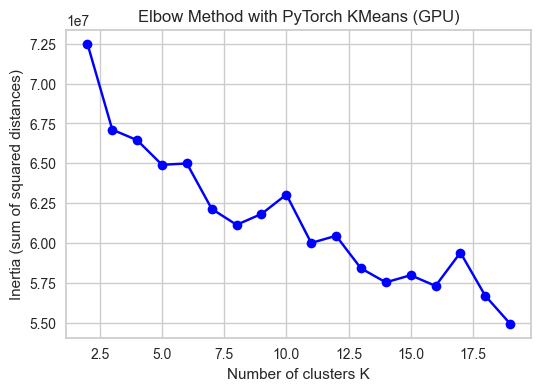

In [32]:
import torch
from kmeans_pytorch import kmeans
import matplotlib.pyplot as plt

# X_tensor should be your data tensor on GPU
# e.g., X_tensor = torch.tensor(X_scaled, dtype=torch.float32).cuda()

Ks = range(2,20 )   # Try k from 2 to 10
inertias = []

for k in Ks:
    # Run KMeans on GPU
    cluster_ids, cluster_centers = kmeans(
        X=X_tensor, 
        num_clusters=k, 
        distance='euclidean', 
        device=torch.device('cuda:0')
    )
    
    # Move cluster_centers to GPU if it's on CPU
    cluster_centers = cluster_centers.to(X_tensor.device)
    
    # Compute inertia manually: sum of squared distances to cluster center
    distances = torch.norm(X_tensor - cluster_centers[cluster_ids], dim=1) ** 2
    inertia = distances.sum().item()
    inertias.append(inertia)
    print(f"k={k}, inertia={inertia:.2f}")

# Plot Elbow
plt.figure(figsize=(6,4))
plt.plot(Ks, inertias, 'o-', color='blue')
plt.xlabel("Number of clusters K")
plt.ylabel("Inertia (sum of squared distances)")
plt.title("Elbow Method with PyTorch KMeans (GPU)")
plt.show()


In [34]:
# -----------------------------
# 7️⃣ Print the optimal number of clusters (from Elbow)
# -----------------------------
best_k = Ks[np.argmin(inertias)]  # Get the k with the lowest inertia
print(f"\n✅ Optimal number of clusters (Elbow): {best_k}")


✅ Optimal number of clusters (Elbow): 19


In [35]:
# -----------------------------
# 7️⃣ Run KMeans on GPU
# -----------------------------
num_clusters = best_k
cluster_ids, cluster_centers = kmeans(
    X=X_tensor,
    num_clusters=num_clusters,
    distance='euclidean',
    device=torch.device('cuda:0')
)

print("Cluster IDs shape:", cluster_ids.shape)
print("Cluster centers shape:", cluster_centers.shape)

df_model['cluster1'] = cluster_ids
df_model['cluster1'].value_counts()



running k-means on cuda:0..


[running kmeans]: 47it [19:12, 24.53s/it, center_shift=0.000085, iteration=47, tol=0.000100]   


Cluster IDs shape: torch.Size([64924])
Cluster centers shape: torch.Size([19, 6269])


In [36]:
df_model['cluster1'] = cluster_ids
df_model['cluster1'].value_counts()


C:\Users\arunkumara\AppData\Local\Temp\4\ipykernel_6812\1404637937.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_model['cluster1'] = cluster_ids


cluster1
5     16315
2     10758
15     5681
0      4517
12     4351
9      4312
17     4119
7      3045
6      2837
16     1737
11     1518
10     1304
14     1278
8       939
1       925
13      567
18      502
3       145
4        74
Name: count, dtype: int64

In [ ]:
# ----------------------------------------------
# 3️⃣ FAST elbow using MiniBatch KMeans
# ----------------------------------------------
K_range = range(2, 10)
inertia_scores = []

for k in K_range:
    mbk = MiniBatchKMeans(
        n_clusters=k,
        random_state=42,
        batch_size=512,
        max_iter=100
    )
    mbk.fit(X_pca)
    inertia_scores.append(mbk.inertia_)

# ----------------------------------------------
# 4️⃣ Plot elbow
# ----------------------------------------------
plt.plot(K_range, inertia_scores, marker='o')
plt.xlabel("K")
plt.ylabel("Inertia")
plt.title("FAST Elbow Method (PCA + MiniBatchKMeans)")
plt.grid(True)
plt.show()

# ----------------------------------------------
# 5️⃣ Best K = point where slope reduces most
# ----------------------------------------------
best_k = K_range[np.argmin(np.gradient(np.gradient(inertia_scores)))]
print(f"\n✅ Optimal K (fast method): {best_k}")


# dENIED

In [43]:
cols = ["DX_Change_Status", "DX_Type_Status", "DX_Set_Change_Status", "PX_Set_Change_Status","DRG_Status"]
df5 = df2[~(df2[cols] == "No Change").all(axis=1)].copy()
df5.info()


<class 'pandas.core.frame.DataFrame'>
Index: 9030 entries, 33870 to 886028
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Payor                       9030 non-null   object 
 1   Client                      9030 non-null   object 
 2   PaymentType                 9030 non-null   object 
 3   Group_Type                  9027 non-null   object 
 4   Payments                    9030 non-null   float64
 5   Provider_ID                 9030 non-null   object 
 6   HospitalName                9030 non-null   object 
 7   LOS                         9030 non-null   object 
 8   ADRG                        9030 non-null   object 
 9   AGE                         9030 non-null   object 
 10  LOB                         9030 non-null   object 
 11  PRIM_DX                     9030 non-null   object 
 12  B_DRG                       8811 non-null   object 
 13  B_PRIMDX                    8457

In [44]:
df5['PRIM_DX'].value_counts()

PRIM_DX
A419       2289
J9601       643
N179        642
J9621       501
J441        362
A4151       289
J189        225
A4189       211
G9341       140
A4159       133
A4101       101
N390         98
A4102        92
T83511A      75
I130         63
N3000        62
A4150        58
I110         54
A4181        51
U071         44
J690         43
E222         42
I214         40
I480         40
T83518A      40
A4152        39
A409         34
J9622        34
E11649       33
A403         32
K8590        29
I639         28
A401         27
J159         26
A411         25
A414         24
A400         23
I2699        23
T80211A      23
E1169        23
I4891        22
A408         22
G928         22
T8144XA      21
J9602        21
J439         21
I674         21
J101         20
K56609       20
N170         20
G9340        19
K921         19
J1000        18
T796XXA      18
T83512A      17
S065XAA      17
E1010        17
E871         17
E1110        16
J440         16
S72141A      16
I63511       15


## PrimDX = a419

In [45]:
df6 = df5[df5['PRIM_DX']=='A419'].copy()
df6.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2289 entries, 33873 to 885965
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Payor                       2289 non-null   object 
 1   Client                      2289 non-null   object 
 2   PaymentType                 2289 non-null   object 
 3   Group_Type                  2287 non-null   object 
 4   Payments                    2289 non-null   float64
 5   Provider_ID                 2289 non-null   object 
 6   HospitalName                2289 non-null   object 
 7   LOS                         2289 non-null   object 
 8   ADRG                        2289 non-null   object 
 9   AGE                         2289 non-null   object 
 10  LOB                         2289 non-null   object 
 11  PRIM_DX                     2289 non-null   object 
 12  B_DRG                       2261 non-null   object 
 13  B_PRIMDX                    2148

In [46]:
df6['A_DX_Set'].value_counts()

A_DX_Set
[R6520]                                                                                                                                                           87
[J189, J9601]                                                                                                                                                     60
[J189]                                                                                                                                                            47
[G9341]                                                                                                                                                           32
[N186]                                                                                                                                                            28
[G9341, R6520]                                                                                                                                                    25
[

### A_DX_set == R6520 (alone)

In [47]:
df7 = df6[df6['A_DX_Set'].apply(lambda x: x[0] == "R6520" if isinstance(x, list) and len(x) == 1 else False)].copy()


In [48]:
unique_counts = {}

# Count using for-loop
for row in df7['B_DX_Set']:
    for val in row:
        if val not in unique_counts:
            unique_counts[val] = 0
        unique_counts[val] += 1

# Sort dictionary by descending count
unique_counts_desc = dict(
    sorted(unique_counts.items(), key=lambda x: x[1], reverse=True)
)

unique_counts_desc



{'N179': 47,
 'E871': 27,
 'I5032': 13,
 'I130': 10,
 'D62': 7,
 'I5022': 6,
 'Z6841': 5,
 'E870': 5,
 'E872': 4,
 'E039': 4,
 'Z20822': 4,
 'E440': 4,
 'I4820': 4,
 'J9611': 4,
 'L03115': 4,
 'Z6842': 3,
 'E785': 3,
 'I10': 3,
 'K219': 3,
 'Z7984': 3,
 'I429': 3,
 'E1152': 3,
 'E860': 3,
 'I2510': 3,
 'Z7982': 3,
 'I248': 2,
 'K56600': 2,
 'E119': 2,
 'F419': 2,
 'M86172': 2,
 'F17210': 2,
 'Z7901': 2,
 'Z794': 2,
 'Z79890': 2,
 'Z79899': 2,
 'M869': 2,
 'N136': 2,
 'L03116': 2,
 'B3749': 2,
 'C787': 2,
 'F1120': 2,
 'J441': 2,
 'N184': 2,
 'Z87891': 2,
 'M6282': 2,
 'Z6843': 2,
 'I96': 2,
 'Z681': 2,
 'F331': 2,
 'E874': 1,
 'B002': 1,
 'G8114': 1,
 'R579': 1,
 'F322': 1,
 'F32A': 1,
 'G2581': 1,
 'G43909': 1,
 'I951': 1,
 'R4182': 1,
 'Z66': 1,
 'Z96641': 1,
 'Z96653': 1,
 'I70262': 1,
 'L97409': 1,
 'N178': 1,
 'T8131XA': 1,
 'F05': 1,
 'Z1623': 1,
 'I69354': 1,
 'K567': 1,
 'N454': 1,
 'E1122': 1,
 'G4733': 1,
 'I129': 1,
 'I4891': 1,
 'K529': 1,
 'N1830': 1,
 'Z8616': 1,
 'Z8679'

#### Bdx_set = N179

In [49]:
df8 = df7[df7['B_DX_Set'].apply(lambda x: "N179" in x)].copy()
df8.info()


<class 'pandas.core.frame.DataFrame'>
Index: 47 entries, 246267 to 856537
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Payor                       47 non-null     object 
 1   Client                      47 non-null     object 
 2   PaymentType                 47 non-null     object 
 3   Group_Type                  47 non-null     object 
 4   Payments                    47 non-null     float64
 5   Provider_ID                 47 non-null     object 
 6   HospitalName                47 non-null     object 
 7   LOS                         47 non-null     object 
 8   ADRG                        47 non-null     object 
 9   AGE                         47 non-null     object 
 10  LOB                         47 non-null     object 
 11  PRIM_DX                     47 non-null     object 
 12  B_DRG                       47 non-null     object 
 13  B_PRIMDX                    47 no

In [50]:
df8['total_payment'] = df8.groupby(['PRIM_DX', 'Provider_ID'])['Payments'].transform('sum')
df8['avg_payment'] = df8.groupby(['PRIM_DX', 'Provider_ID'])['Payments'].transform('mean')
df8['max_payment'] = df8.groupby(['PRIM_DX', 'Provider_ID'])['Payments'].transform('max')
df8['min_payment'] = df8.groupby(['PRIM_DX', 'Provider_ID'])['Payments'].transform('min')
df8['sd_payment'] = df8.groupby(['PRIM_DX', 'Provider_ID'])['Payments'].transform('std')

df8.head()

,Payor,Client,PaymentType,Group_Type,Payments,Provider_ID,HospitalName,LOS,ADRG,AGE,LOB,PRIM_DX,B_DRG,B_PRIMDX,InitialDeterminationStatus,IDSavings,AdjustedSavings,A_PX_List,B_PX_List,B_PRIMDX_Clean,A_DX_Type,A_DX_Set,B_DX_Type,B_DX_Set,A_PX_count,B_PX_count,A_DX_Count,B_DX_Count,DX_Change_Status,DX_Type_Status,DRG_Status,DX_Set_Change_Status,PX_Set_Change_Status,total_payment,avg_payment,max_payment,min_payment,sd_payment
246267,Strat,Hum,postpay,01,4406.35,000028386A,WILLIAM BEAUMONT HOSPITAL,10,872,82,MEP3I,A419,392,K5732 - CC,Denied,1553.75,1553.75,[30233N1],[30233N1],K5732,MCC,[R6520],CC,"[E874, N179]",1,1,1,2,Change A419 → K5732,Change MCC → CC,Change 872 → 392,"Change ['R6520'] → ['E874', 'N179']",No Change,4406.35,4406.350,4406.35,4406.35,NaN
253066,Strat,Hum,postpay,01,7385.45,593458145N,TAMPA GENERAL HOSPITAL,8,872,74,MEP3I,A419,603,L03115 - CC,Denied,911.14,0,[],[],L03115,MCC,[R6520],CC,"[B002, E871, N179, Z6842]",0,0,1,4,Change A419 → L03115,Change MCC → CC,Change 872 → 603,"Change ['R6520'] → ['B002', 'E871', 'N179', 'Z6842']",No Change,15477.25,7738.625,8091.80,7385.45,499.464875
257905,Strat,Hum,postpay,01,3517.53,002008874A,ST MARYS HOSPITAL MADISON,4,872,70,MEP3I,A419,690,N390 - CC,Denied,1645.01,1645.01,[],[],N390,MCC,[R6520],CC,"[G8114, I248, K56600, N179]",0,0,1,4,Change A419 → N390,Change MCC → CC,Change 872 → 690,"Change ['R6520'] → ['G8114', 'I248', 'K56600', 'N179']",No Change,3517.53,3517.530,3517.53,3517.53,NaN
275624,Strat,Hum,postpay,01,6823.57,000060510C,PIKEVILLE MEDICAL CENTER,8,872,76,MEP3I,A419,690,N390 - CC,Denied,6823.57,1996.77,[0D728ZZ],[0D728ZZ],N390,MCC,[R6520],CC,"[I130, I5032, N179]",1,1,1,3,Change A419 → N390,Change MCC → CC,Change 872 → 690,"Change ['R6520'] → ['I130', 'I5032', 'N179']",No Change,6823.57,6823.570,6823.57,6823.57,NaN
299410,Strat,Hum,postpay,01,13444.24,000198215,POPLAR BLUFF REGIONAL MEDICAL,19,854,83,MEP3I,A419,580,L03116 - CC,Denied,2052.57,0,"[047L3Z1, 047N3Z1, B246ZZZ, B4101ZZ, B41F1ZZ, B41G1ZZ]","[047L3Z1, 047N3Z1, B246ZZZ, B4101ZZ, B41F1ZZ, B41G1ZZ]",L03116,MCC,[R6520],CC,"[I130, I429, I5022, N179]",6,6,1,4,Change A419 → L03116,Change MCC → CC,Change 854 → 580,"Change ['R6520'] → ['I130', 'I429', 'I5022', 'N179']",No Change,13444.24,13444.240,13444.24,13444.24,NaN


In [53]:
import numpy as np

In [ ]:
df8['avg_payment_by_comb'] = df8.groupby(['PRIM_DX'])['avg_payment'].transform('mean')
df8['sd_payment_by_comb'] = df8.groupby(['PRIM_DX'])['avg_payment'].transform('std')

df8['Upper_Limt'] = df8['avg_payment_by_comb'] + (3 * df8['sd_payment_by_comb'])
df8['Lower_Limt'] = df8['avg_payment_by_comb'] - (3 * df8['sd_payment_by_comb'])
df8['claim_status'] = np.where(
    (df8['avg_payment_by_comb'] > df8['Upper_Limt']) |
    (df8['avg_payment_by_comb'] < df8['Lower_Limt']),
    'Outlier',
    'Normal'
)
df8['claim_status'].value_counts()

claim_status
Normal    47
Name: count, dtype: int64

Pearson Corr - Payments vs Age: -0.15983041692266609
Pearson Corr - Payments vs LOS: 0.5531246569797679
Spearman Corr - Payments vs Age: -0.15869900960619507
Spearman Corr - Payments vs LOS: 0.2208367345683241


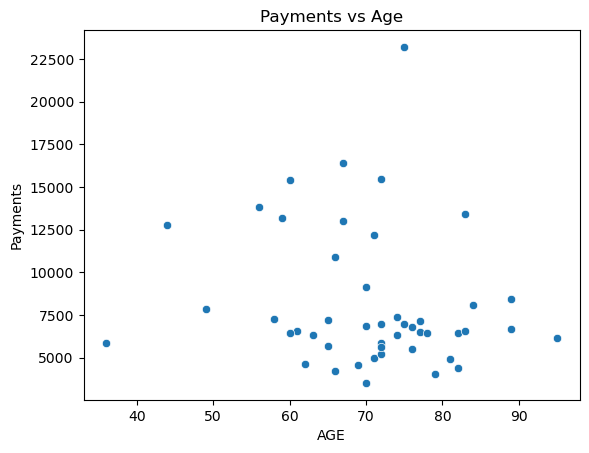

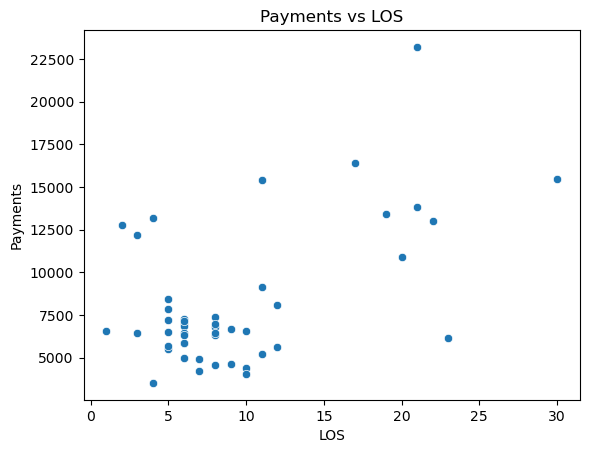

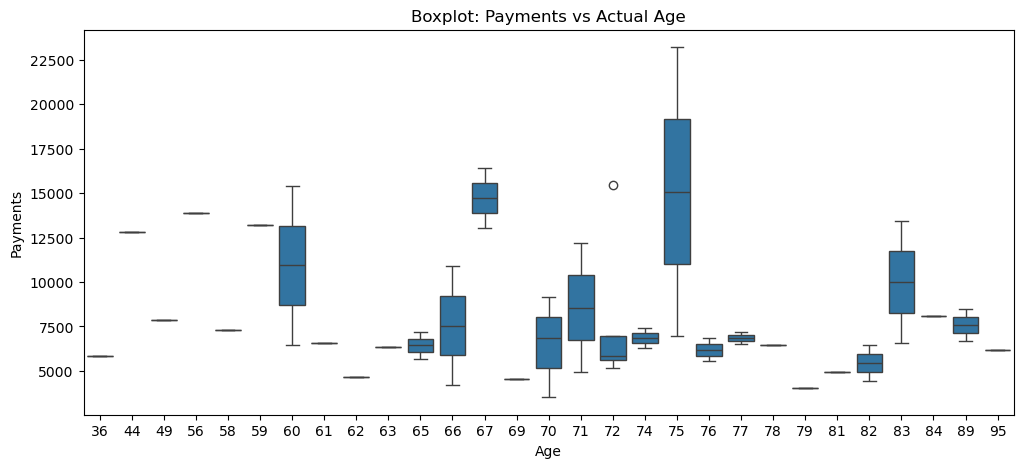

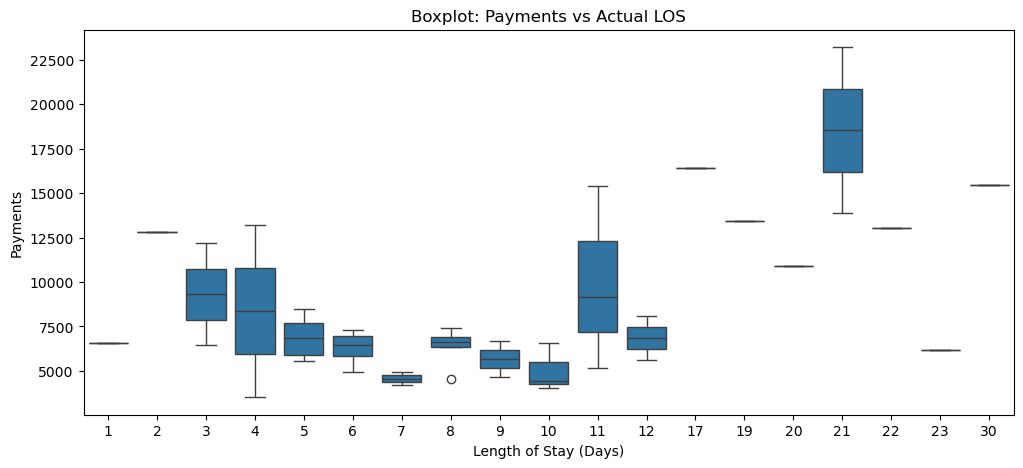

In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# -------------------------------------------
# 1️⃣ Ensure numeric columns
# -------------------------------------------

df = df8.copy()

df['AGE'] = pd.to_numeric(df['AGE'], errors='coerce')
df['LOS'] = pd.to_numeric(df['LOS'], errors='coerce')
df['Payments'] = pd.to_numeric(df['Payments'], errors='coerce')

# -------------------------------------------
# 2️⃣ Correlations (Payments vs AGE & LOS)
# -------------------------------------------

corr_age = df['Payments'].corr(df['AGE'], method='pearson')
corr_los = df['Payments'].corr(df['LOS'], method='pearson')

corr_age_spearman = df['Payments'].corr(df['AGE'], method='spearman')
corr_los_spearman = df['Payments'].corr(df['LOS'], method='spearman')

print("Pearson Corr - Payments vs Age:", corr_age)
print("Pearson Corr - Payments vs LOS:", corr_los)
print("Spearman Corr - Payments vs Age:", corr_age_spearman)
print("Spearman Corr - Payments vs LOS:", corr_los_spearman)

# -------------------------------------------
# 3️⃣ Scatter Plots
# -------------------------------------------

sns.scatterplot(x='AGE', y='Payments', data=df)
plt.title("Payments vs Age")
plt.show()

sns.scatterplot(x='LOS', y='Payments', data=df)
plt.title("Payments vs LOS")
plt.show()

# -------------------------------------------
# 4️⃣ Boxplot using actual AGE (continuous)
# -------------------------------------------

plt.figure(figsize=(12, 5))
sns.boxplot(x='AGE', y='Payments', data=df)
plt.title("Boxplot: Payments vs Actual Age")
plt.xlabel("Age")
plt.ylabel("Payments")
plt.show()

# -------------------------------------------
# 5️⃣ Boxplot using actual LOS (continuous)
# -------------------------------------------

plt.figure(figsize=(12, 5))
sns.boxplot(x='LOS', y='Payments', data=df)
plt.title("Boxplot: Payments vs Actual LOS")
plt.xlabel("Length of Stay (Days)")
plt.ylabel("Payments")
plt.show()


In [58]:
import pandas as pd

df = df8.copy()

# Function to detect outliers for each age group
def find_outliers(group):
    q1 = group['Payments'].quantile(0.25)
    q3 = group['Payments'].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    
    # mark outliers
    return group[(group['Payments'] < lower) | (group['Payments'] > upper)]

# Apply per AGE group
outliers_df = df.groupby('AGE', group_keys=False).apply(find_outliers)

# Show outliers
outliers_df.head()


C:\Users\Akumar\AppData\Local\Temp\5\ipykernel_7812\2696985599.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  outliers_df = df.groupby('AGE', group_keys=False).apply(find_outliers)


,Payor,Client,PaymentType,Group_Type,Payments,Provider_ID,HospitalName,LOS,ADRG,AGE,LOB,PRIM_DX,B_DRG,B_PRIMDX,InitialDeterminationStatus,IDSavings,AdjustedSavings,A_PX_List,B_PX_List,B_PRIMDX_Clean,A_DX_Type,A_DX_Set,B_DX_Type,B_DX_Set,A_PX_count,B_PX_count,A_DX_Count,B_DX_Count,DX_Change_Status,DX_Type_Status,DRG_Status,DX_Set_Change_Status,PX_Set_Change_Status,total_payment,avg_payment,max_payment,min_payment,sd_payment,avg_payment_by_comb,sd_payment_by_comb,Upper_Limt,Lower_Limt,claim_status
715697,Strat,Hum,postpay,01,15457.64,582026750,WELLSTAR DOUGLAS HOSPITAL,30,854,72,MEP3I,A419,660,N136 - CC,Denied,4786.57,0,"[0T773DZ, 0T774DZ, 0T9440Z, 0TC14ZZ, 0TC74ZZ]","[0T773DZ, 0T774DZ, 0T9440Z, 0TC14ZZ, 0TC74ZZ]",N136,MCC,[R6520],CC,"[D61818, D62, E440, I4820, I69954, N179, N184]",5,5,1,7,Change A419 → N136,Change MCC → CC,Change 854 → 660,"Change ['R6520'] → ['D61818', 'D62', 'E440', 'I4820', 'I69954', 'N179', 'N184']",No Change,15457.64,15457.64,15457.64,15457.64,NaN,8156.316809,3931.564183,19951.009357,-3638.37574,Normal


In [59]:
# Apply per AGE group
outliers_df = df.groupby('LOS', group_keys=False).apply(find_outliers)

# Show outliers
outliers_df.head()

C:\Users\Akumar\AppData\Local\Temp\5\ipykernel_7812\943348638.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  outliers_df = df.groupby('LOS', group_keys=False).apply(find_outliers)


,Payor,Client,PaymentType,Group_Type,Payments,Provider_ID,HospitalName,LOS,ADRG,AGE,LOB,PRIM_DX,B_DRG,B_PRIMDX,InitialDeterminationStatus,IDSavings,AdjustedSavings,A_PX_List,B_PX_List,B_PRIMDX_Clean,A_DX_Type,A_DX_Set,B_DX_Type,B_DX_Set,A_PX_count,B_PX_count,A_DX_Count,B_DX_Count,DX_Change_Status,DX_Type_Status,DRG_Status,DX_Set_Change_Status,PX_Set_Change_Status,total_payment,avg_payment,max_payment,min_payment,sd_payment,avg_payment_by_comb,sd_payment_by_comb,Upper_Limt,Lower_Limt,claim_status
668804,Strat,Hum,postpay,01,4551.82,851608328,PENN STATE HAMPDEN MEDICAL CEN,8,872,69,MEP3I,A419,603,L03115 - CC,Denied,641.74,0,[],[],L03115,MCC,[R6520],CC,"[E871, N179]",0,0,1,2,Change A419 → L03115,Change MCC → CC,Change 872 → 603,"Change ['R6520'] → ['E871', 'N179']",No Change,4551.82,4551.82,4551.82,4551.82,NaN,8156.316809,3931.564183,19951.009357,-3638.37574,Normal


#### E871

In [67]:
df9 = df7[df7['B_DX_Set'].apply(lambda x: "E871" in x)].copy()
df9.info()


<class 'pandas.core.frame.DataFrame'>
Index: 27 entries, 251124 to 856537
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Payor                       27 non-null     object 
 1   Client                      27 non-null     object 
 2   PaymentType                 27 non-null     object 
 3   Group_Type                  27 non-null     object 
 4   Payments                    27 non-null     float64
 5   Provider_ID                 27 non-null     object 
 6   HospitalName                27 non-null     object 
 7   LOS                         27 non-null     object 
 8   ADRG                        27 non-null     object 
 9   AGE                         27 non-null     object 
 10  LOB                         27 non-null     object 
 11  PRIM_DX                     27 non-null     object 
 12  B_DRG                       27 non-null     object 
 13  B_PRIMDX                    27 no

In [68]:
df9['total_payment'] = df9.groupby(['PRIM_DX', 'Provider_ID'])['Payments'].transform('sum')
df9['avg_payment'] = df9.groupby(['PRIM_DX', 'Provider_ID'])['Payments'].transform('mean')
df9['max_payment'] = df9.groupby(['PRIM_DX', 'Provider_ID'])['Payments'].transform('max')
df9['min_payment'] = df9.groupby(['PRIM_DX', 'Provider_ID'])['Payments'].transform('min')
df9['sd_payment'] = df9.groupby(['PRIM_DX', 'Provider_ID'])['Payments'].transform('std')

df9.head()

,Payor,Client,PaymentType,Group_Type,Payments,Provider_ID,HospitalName,LOS,ADRG,AGE,LOB,PRIM_DX,B_DRG,B_PRIMDX,InitialDeterminationStatus,IDSavings,AdjustedSavings,A_PX_List,B_PX_List,B_PRIMDX_Clean,A_DX_Type,A_DX_Set,B_DX_Type,B_DX_Set,A_PX_count,B_PX_count,A_DX_Count,B_DX_Count,DX_Change_Status,DX_Type_Status,DRG_Status,DX_Set_Change_Status,PX_Set_Change_Status,total_payment,avg_payment,max_payment,min_payment,sd_payment
251124,Strat,Hum,postpay,01,5594.19,000060298B,BAPTIST MEMORIAL HOSP DESOTO,5,872,66,MEP3I,A419,603,L03115 - CC,Denied,886.61,0,[],[],L03115,MCC,[R6520],CC,[E871],0,0,1,1,Change A419 → L03115,Change MCC → CC,Change 872 → 603,Change ['R6520'] → ['E871'],No Change,5594.19,5594.19,5594.19,5594.19,NaN
253066,Strat,Hum,postpay,01,7385.45,593458145N,TAMPA GENERAL HOSPITAL,8,872,74,MEP3I,A419,603,L03115 - CC,Denied,911.14,0,[],[],L03115,MCC,[R6520],CC,"[B002, E871, N179, Z6842]",0,0,1,4,Change A419 → L03115,Change MCC → CC,Change 872 → 603,"Change ['R6520'] → ['B002', 'E871', 'N179', 'Z6842']",No Change,7385.45,7385.45,7385.45,7385.45,NaN
266846,Strat,Hum,postpay,01,5204.62,000045813,LIMA MEMORIAL HOSPITAL,5,872,47,MEP3I,A419,683,N179 - CC,Denied,917.04,0,"[03HC33Z, 05HM33Z]","[03HC33Z, 05HM33Z]",N179,MCC,[R6520],CC,"[E871, E872, R579]",2,2,1,3,Change A419 → N179,Change MCC → CC,Change 872 → 683,"Change ['R6520'] → ['E871', 'E872', 'R579']",No Change,5204.62,5204.62,5204.62,5204.62,NaN
283045,Strat,Hum,postpay,01,4637.04,581123037T,REDMOND REGIONAL MEDICAL CTR,16,872,49,MEP3I,A419,603,L03115 - CC,Denied,948.10,0,[],[],L03115,MCC,[R6520],CC,"[E871, F322, I5022, Z6841]",0,0,1,4,Change A419 → L03115,Change MCC → CC,Change 872 → 603,"Change ['R6520'] → ['E871', 'F322', 'I5022', 'Z6841']",No Change,4637.04,4637.04,4637.04,4637.04,NaN
324961,Strat,Hum,postpay,01,5417.72,610445850,ST ELIZABETH HEALTHCARE,8,872,83,MER32,A419,690,N390 - CC,Denied,1541.10,0,[],[],N390,MCC,[R6520],CC,"[E871, F05, Z1623]",0,0,1,3,Change A419 → N390,Change MCC → CC,Change 872 → 690,"Change ['R6520'] → ['E871', 'F05', 'Z1623']",No Change,5417.72,5417.72,5417.72,5417.72,NaN


In [69]:
df9['avg_payment_by_comb'] = df9.groupby(['PRIM_DX'])['avg_payment'].transform('mean')
df9['sd_payment_by_comb'] = df9.groupby(['PRIM_DX'])['avg_payment'].transform('std')

df9['Upper_Limt'] = df9['avg_payment_by_comb'] + (3 * df9['sd_payment_by_comb'])
df9['Lower_Limt'] = df9['avg_payment_by_comb'] - (3 * df9['sd_payment_by_comb'])
df9['claim_status'] = np.where(
    (df9['avg_payment_by_comb'] > df9['Upper_Limt']) |
    (df9['avg_payment_by_comb'] < df9['Lower_Limt']),
    'Outlier',
    'Normal'
)
df9['claim_status'].value_counts()

claim_status
Normal    27
Name: count, dtype: int64

Pearson Corr - Payments vs Age: -0.17000867784513984
Pearson Corr - Payments vs LOS: -0.011449955634872323
Spearman Corr - Payments vs Age: -0.13309907794986212
Spearman Corr - Payments vs LOS: -0.4654411351360667


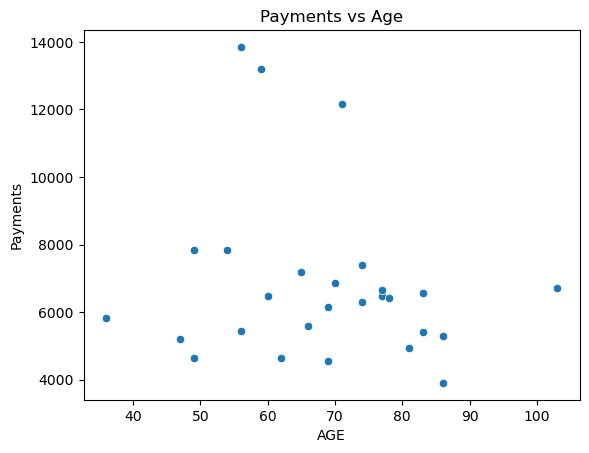

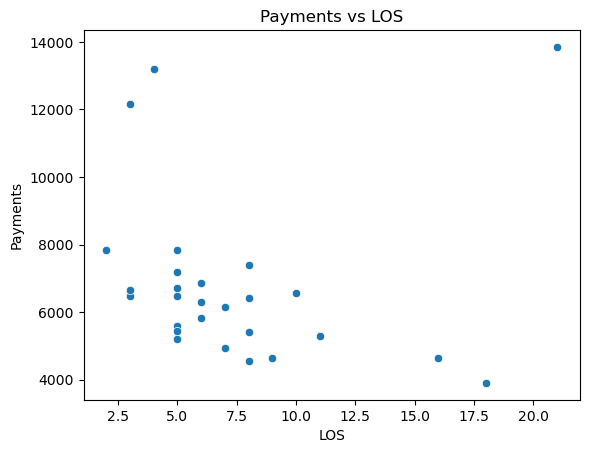

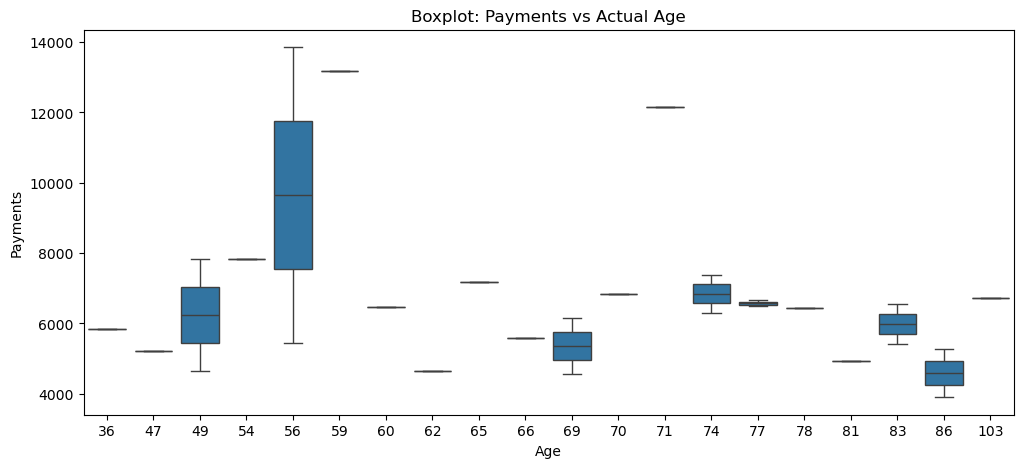

C:\Users\Akumar\AppData\Local\Temp\5\ipykernel_7812\3173883856.py:67: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  outliers_df = df.groupby('AGE', group_keys=False).apply(find_outliers)


Empty DataFrame
Columns: [Payor, Client, PaymentType, Group_Type, Payments, Provider_ID, HospitalName, LOS, ADRG, AGE, LOB, PRIM_DX, B_DRG, B_PRIMDX, InitialDeterminationStatus, IDSavings, AdjustedSavings, A_PX_List, B_PX_List, B_PRIMDX_Clean, A_DX_Type, A_DX_Set, B_DX_Type, B_DX_Set, A_PX_count, B_PX_count, A_DX_Count, B_DX_Count, DX_Change_Status, DX_Type_Status, DRG_Status, DX_Set_Change_Status, PX_Set_Change_Status, total_payment, avg_payment, max_payment, min_payment, sd_payment, avg_payment_by_comb, sd_payment_by_comb, Upper_Limt, Lower_Limt, claim_status]
Index: []


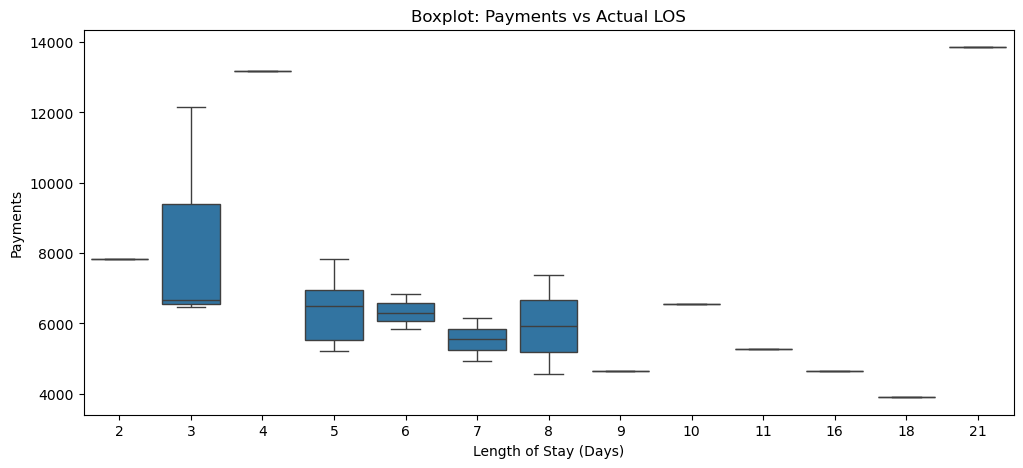

Empty DataFrame
Columns: [Payor, Client, PaymentType, Group_Type, Payments, Provider_ID, HospitalName, LOS, ADRG, AGE, LOB, PRIM_DX, B_DRG, B_PRIMDX, InitialDeterminationStatus, IDSavings, AdjustedSavings, A_PX_List, B_PX_List, B_PRIMDX_Clean, A_DX_Type, A_DX_Set, B_DX_Type, B_DX_Set, A_PX_count, B_PX_count, A_DX_Count, B_DX_Count, DX_Change_Status, DX_Type_Status, DRG_Status, DX_Set_Change_Status, PX_Set_Change_Status, total_payment, avg_payment, max_payment, min_payment, sd_payment, avg_payment_by_comb, sd_payment_by_comb, Upper_Limt, Lower_Limt, claim_status]
Index: []


C:\Users\Akumar\AppData\Local\Temp\5\ipykernel_7812\3173883856.py:82: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  outliers_df1 = df.groupby('LOS', group_keys=False).apply(find_outliers)


In [70]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# -------------------------------------------
# 1️⃣ Ensure numeric columns
# -------------------------------------------

df = df9.copy()

df['AGE'] = pd.to_numeric(df['AGE'], errors='coerce')
df['LOS'] = pd.to_numeric(df['LOS'], errors='coerce')
df['Payments'] = pd.to_numeric(df['Payments'], errors='coerce')

# -------------------------------------------
# 2️⃣ Correlations (Payments vs AGE & LOS)
# -------------------------------------------

corr_age = df['Payments'].corr(df['AGE'], method='pearson')
corr_los = df['Payments'].corr(df['LOS'], method='pearson')

corr_age_spearman = df['Payments'].corr(df['AGE'], method='spearman')
corr_los_spearman = df['Payments'].corr(df['LOS'], method='spearman')

print("Pearson Corr - Payments vs Age:", corr_age)
print("Pearson Corr - Payments vs LOS:", corr_los)
print("Spearman Corr - Payments vs Age:", corr_age_spearman)
print("Spearman Corr - Payments vs LOS:", corr_los_spearman)

# Function to detect outliers for each age group
def find_outliers(group):
    q1 = group['Payments'].quantile(0.25)
    q3 = group['Payments'].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    
    # mark outliers
    return group[(group['Payments'] < lower) | (group['Payments'] > upper)]



# -------------------------------------------
# 3️⃣ Scatter Plots
# -------------------------------------------

sns.scatterplot(x='AGE', y='Payments', data=df)
plt.title("Payments vs Age")
plt.show()

sns.scatterplot(x='LOS', y='Payments', data=df)
plt.title("Payments vs LOS")
plt.show()

# -------------------------------------------
# 4️⃣ Boxplot using actual AGE (continuous)
# -------------------------------------------

plt.figure(figsize=(12, 5))
sns.boxplot(x='AGE', y='Payments', data=df)
plt.title("Boxplot: Payments vs Actual Age")
plt.xlabel("Age")
plt.ylabel("Payments")
plt.show()

# Apply per AGE group
outliers_df = df.groupby('AGE', group_keys=False).apply(find_outliers)

# Show outliers
print(outliers_df.head())
# -------------------------------------------
# 5️⃣ Boxplot using actual LOS (continuous)
# -------------------------------------------

plt.figure(figsize=(12, 5))
sns.boxplot(x='LOS', y='Payments', data=df)
plt.title("Boxplot: Payments vs Actual LOS")
plt.xlabel("Length of Stay (Days)")
plt.ylabel("Payments")
plt.show()

outliers_df1 = df.groupby('LOS', group_keys=False).apply(find_outliers)

# Show outliers
print(outliers_df1.head())